<div align="center">
  <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" width="70%" style="min-width: 300px; max-width: 600px;">
  <h1>INF396 - Introducción a la Ciencia de Datos</h1>
  <h3 style="color: #555;">Tarea #2</h3>
  <p>
    <strong>Gabriel Omar Venegas Ortiz</strong><br>
    <em>202104676-3</em><br>
    <em>gabriel.venegaso@usm.cl</em>
  </p>
</div>

<hr>

# Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
import h5py
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, KFold, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.exceptions import ConvergenceWarning

# Regresión
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Clasifición
from sklearn.metrics import (
    recall_score, precision_score, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from imblearn.pipeline import Pipeline as ImbPipeline # Renombrar para no chocar con sklearn.pipeline
from imblearn.over_sampling import RandomOverSampler # La técnica de sobremuestreo

# Data Load

In [2]:
def cargar_datasets_desde_h5(archivo_h5):
    datasets = {}
    with h5py.File(archivo_h5, "r") as f:
        for grupo in f:
            datasets[grupo] = {}
            for key in f[grupo]:
                datasets[grupo][key] = f[grupo][key][:]
    return datasets

datasets_train = cargar_datasets_desde_h5("datasets_train_651BDBFB.h5")
datasets_train.keys()

dict_keys(['decaimiento_radioactivo', 'dinamica_fluidos', 'fallas_maquinaria', 'fraude', 'mercado_financiero'])

## Funciones utils:

In [3]:
# Realizar predicciones del best_model sobre los mismos datos con los que fue entrenado
def grid(X_scaled, y, cv_stratified, grid_search, flag = 0):
    #flag = 0 clasificación, = 1 regresión.
    if flag:
        full_scoring_metrics = {
        'r2': 'r2',                                    
        'neg_mean_squared_error': 'neg_mean_squared_error', 
        'neg_mean_absolute_error': 'neg_mean_absolute_error', 
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error'
        }
    else:
        full_scoring_metrics = {
        'recall': 'recall',
        'precision': 'precision',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy'
        }
    
    print("\nRealizando búsqueda de hiperparámetros con GridSearchCV...")
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search.fit(X_scaled, y) # Usar los datos escalados aquí
    
    print("\n" + "=" * 50)
    print("Resultados de la Búsqueda de Hiperparámetros")
    print("=" * 50)
    
    best_model = grid_search.best_estimator_
    print(f"\nTipo de mejor modelo: {type(best_model).__name__}")
    
    print(f"Mejor puntuación de ('{grid_search.scoring}'): {grid_search.best_score_:.4f}")
    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
    
    
    print("\n" + "=" * 50)
    print("\nEvaluando el MEJOR MODELO con todas las métricas:")
    print("\n" + "=" * 50)
    
    
    final_results = cross_validate(best_model, X_scaled, y, cv=cv_stratified, scoring=full_scoring_metrics, return_train_score=False)
    print_cv_metrics(final_results)

    print("\n" + "=" * 50)
    print("¡Búsqueda de hiperparámetros y evaluación completadas!")
    
    return best_model


def conf_matrix(X_scaled, y, best_model, cats = ['cero','uno']):
    y_pred_train = best_model.predict(X_scaled)

    cm_train = confusion_matrix(y, y_pred_train)
    
    train_recall = recall_score(y, y_pred_train)
    train_precision = precision_score(y, y_pred_train)
    train_f1 = f1_score(y, y_pred_train)
    train_accuracy = accuracy_score(y, y_pred_train)
    train_roc_auc = roc_auc_score(y, best_model.predict_proba(X_scaled)[:, 1]) # Necesita probabilidades
    
    print("\nMétricas de Rendimiento (sobre conjunto de ENTRENAMIENTO completo):")
    print(f"- Recall: {train_recall:.4f}")
    print(f"- Precision: {train_precision:.4f}")
    print(f"- F1-Score: {train_f1:.4f}")
    print(f"- ROC AUC: {train_roc_auc:.4f}")
    print(f"- Accuracy: {train_accuracy:.4f}")
    
    plt.figure(figsize=(8, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[f'{cats[0]} (0)', f'{cats[1]} (1)'])
    cm_display.plot(cmap='Blues', values_format='d', ax=plt.gca())
    plt.title('Matriz de Confusión del Mejor Modelo (Evaluación en Entrenamiento)')
    plt.show()


def print_cv_metrics(results_dict): 
    print("\nResultados de la validación cruzada estratificada (promedios):")
    for metric_name, scores in results_dict.items():
        if metric_name.startswith('test_'):
            display_name = metric_name[5:].replace('_', ' ').title()
            print(f"- {display_name}: {scores.mean():.4f} +/- {scores.std():.4f}")

def remove_outliers_iqr(df, cols):
    df_filtered = df.copy()
    
    for column in cols:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
        
        num_outliers = len(df) - len(df_filtered)
        print(f"Columna '{column}': Eliminados {num_outliers} outliers.")

    print(df_filtered.shape)
    
    return df_filtered

# Question 1: High-Frequency Trading

In [147]:
# Visualizando cuáles son las llaves para inicializar el set de entrenamiento.
datasets_train['mercado_financiero'].keys()

dict_keys(['X', 'y_class', 'y_reg'])

In [148]:
# Inicializando el set de entrenamiento.
X =  datasets_train["mercado_financiero"]['X']
y_reg = datasets_train["mercado_financiero"]['y_reg']
y_class = datasets_train["mercado_financiero"]['y_class']

In [149]:
# Inicialización de un dataframe de pandas para un manejo más cómodo, sobre todo para el EDA.
columns = ['RSI', 'volatilidad', 'MACD', 'random1', 'random2']
df = pd.DataFrame(X)
df.columns = columns
df['ret_futuro'] = y_reg
df['ret_dir'] = y_class
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199988 entries, 0 to 1199987
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   RSI          1199975 non-null  float64
 1   volatilidad  1199889 non-null  float64
 2   MACD         1199988 non-null  float64
 3   random1      1199988 non-null  float64
 4   random2      1199988 non-null  float64
 5   ret_futuro   1199988 non-null  float64
 6   ret_dir      1199988 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 64.1 MB


In [150]:
# Si elimino los datos NaN simplemente pierdo 99 datos
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199889 entries, 99 to 1199987
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   RSI          1199889 non-null  float64
 1   volatilidad  1199889 non-null  float64
 2   MACD         1199889 non-null  float64
 3   random1      1199889 non-null  float64
 4   random2      1199889 non-null  float64
 5   ret_futuro   1199889 non-null  float64
 6   ret_dir      1199889 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 73.2 MB


### Limpieza de outliers con IQR

In [151]:
df['ret_dir'].value_counts()

ret_dir
1    602961
0    596928
Name: count, dtype: int64

In [152]:

columns = ['RSI', 'volatilidad', 'MACD', 'ret_futuro']
df_fil = remove_outliers_iqr(df, cols=columns)

Columna 'RSI': Eliminados 466043 outliers.
Columna 'volatilidad': Eliminados 509789 outliers.
Columna 'MACD': Eliminados 515361 outliers.
Columna 'ret_futuro': Eliminados 685474 outliers.
(514415, 7)


In [153]:
df_fil['ret_dir'].value_counts()

ret_dir
1    257513
0    256902
Name: count, dtype: int64

## Exploratory Data Analysis

### Violin plots

Análisis: En general es muy dificil distinguir entre direcciones, las distribuciones se asemejan mucho en forma y toman valores similares, se overlapean casi perfectamente. Esto es un problema bastante notable para nuestro clasificador ya que discriminar entre subida y bajada pareciera ser una tarea no trivial.

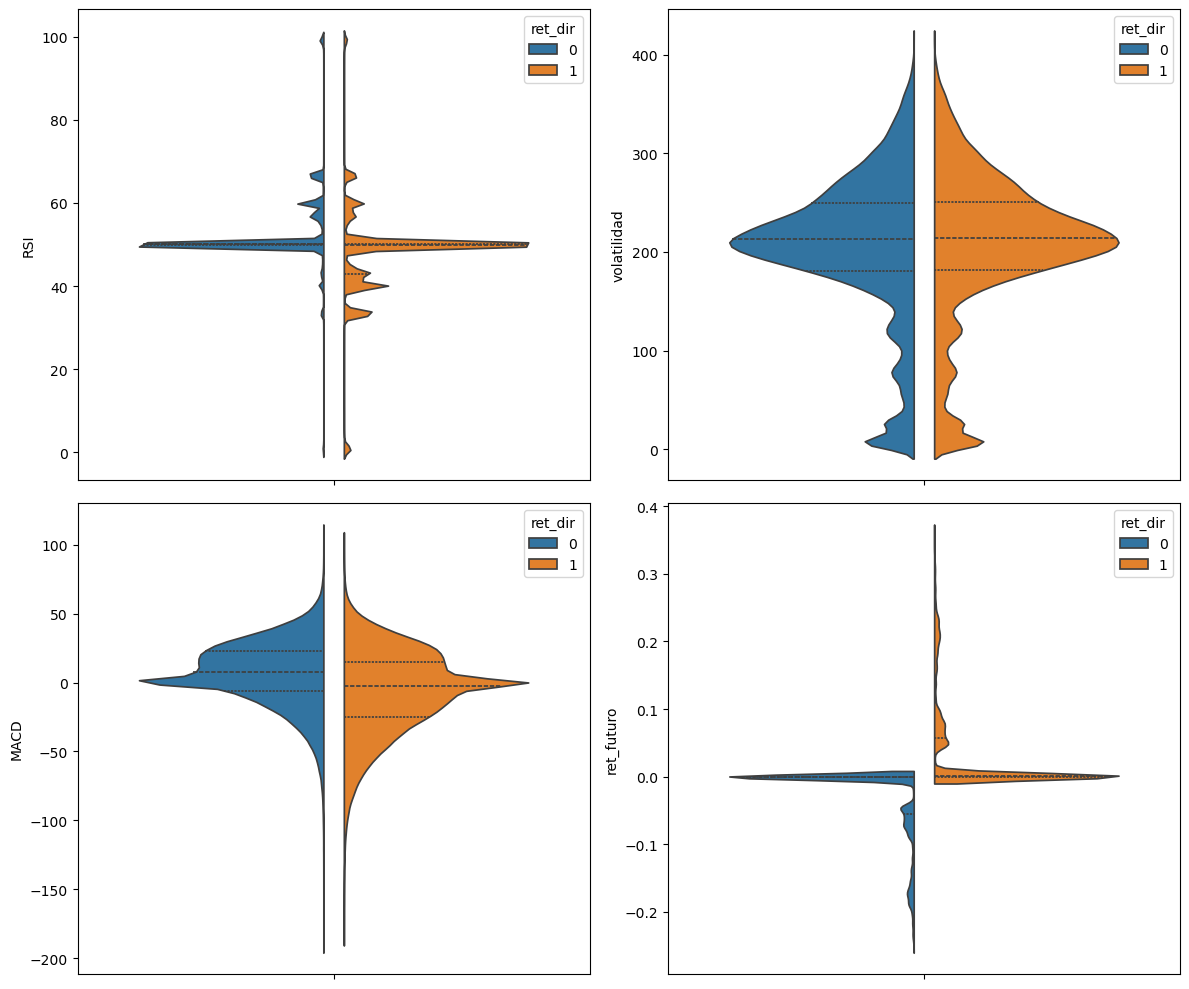

In [22]:
f, axs = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw=dict(width_ratios=[1, 1]))

sns.violinplot(data=df, y='RSI', hue='ret_dir', split=True, gap=.1, inner="quart",ax=axs[0,0])
sns.violinplot(data=df, y='volatilidad', hue='ret_dir', split=True, gap=.1, inner="quart", ax=axs[0,1])
sns.violinplot(data=df, y='MACD', hue='ret_dir', split=True, gap=.1, inner="quart", ax=axs[1,0])
sns.violinplot(data=df, y='ret_futuro', hue='ret_dir', split=True, gap=.1, inner="quart", ax=axs[1,1])

f.tight_layout()
plt.show()

### Autocorrelación RSI

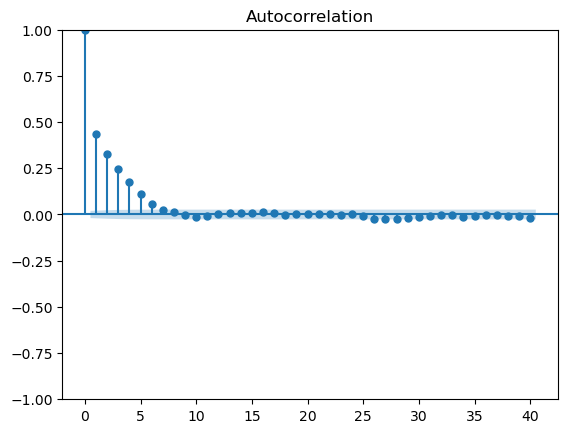

In [154]:
sm.graphics.tsa.plot_acf(x=df_fil['RSI'].iloc[:10000], alpha=0.05, 
                         missing='drop', title='Autocorrelation')
plt.show()

### Autocorrelación volatilidad

El gráfico ACF muestra una alta y persistente autocorrelación positiva con un decaimiento muy lento. Esto indica una fuerte tendencia y memoria a largo plazo en la serie, sugiriendo que no es estacionaria y podría necesitar diferenciación.

In [155]:
sm.graphics.tsa.plot_acf(x=df_fil['volatilidad'].iloc[:10000], alpha=0.05, 
                         missing='drop', title='Autocorrelation')
plt.show()

### Autocorrelación MACD

Este gráfico de correlación presenta una inestabilidad en el primer período, estabilizandose posteriormente y dando a ver unos patrones sinusoidales muy ciclicos

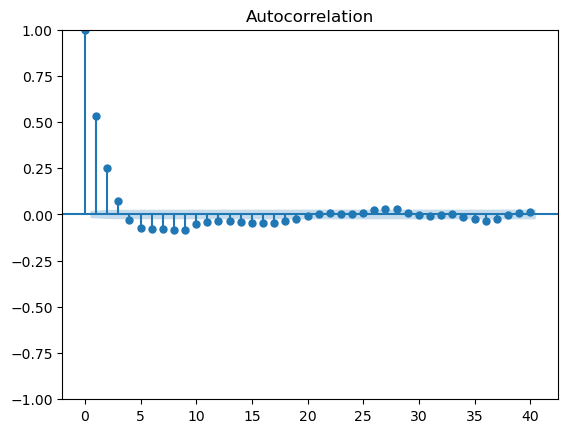

In [156]:
sm.graphics.tsa.plot_acf(x=df_fil['MACD'].iloc[:10000], alpha=0.05, 
                         missing='drop', title='Autocorrelation')
plt.show()

### Autocorrelation retorno Futuro

Este caso es similar al anterior, solamente que luego de 5 se pierde absolutamente toda la correlación y no dejando ver ningún patrón, esto quiere decir que no hay una tendencia que sea estacionaria en este caso. 

In [157]:
sm.graphics.tsa.plot_acf(x=df_fil['ret_futuro'].iloc[:10000], alpha=0.05, 
                         missing='drop', title='Autocorrelation')
plt.show()

### Autocorrelation dirección (sube/baja)

Mismo caso que el anterior.

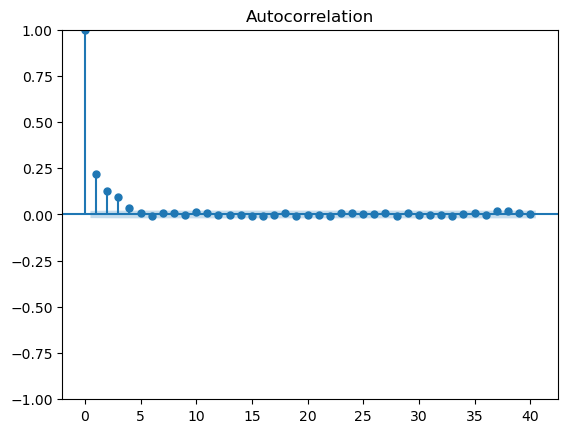

In [158]:
sm.graphics.tsa.plot_acf(x=df_fil['ret_dir'].iloc[:10000], alpha=0.05, 
                         missing='drop', title='Autocorrelation')
plt.show()

## Modelo de regresión

In [81]:
X = df_fil.drop(['ret_futuro', 'ret_dir'].iloc[:10000], axis=1)
y_reg = df_fil['ret_futuro']

### Con RobustScaler

In [70]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDRegressor(random_state=42, verbose=0)
param_grid = {
    'loss': ['huber', 'epsilon_insensitive'],
    'penalty': ['l1','l2', 'elasticnet'],
    'learning_rate': ['optimal', 'adaptive'],
    'alpha': [1e-3, 1e-2, 1e-1], # Fuerza de regularización
    'max_iter': [1000],
    'tol': [1e-3]
}

cv_kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_kfolds,
    scoring='neg_mean_absolute_error', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [69]:
grid(X_scaled, y_reg, cv_kfolds, grid_search, flag=1)


Realizando búsqueda de hiperparámetros con GridSearchCV...

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDRegressor
Mejor puntuación de ('neg_mean_absolute_error'): -0.0002
Mejores hiperparámetros encontrados: {'alpha': 0.1, 'learning_rate': 'adaptive', 'loss': 'huber', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- R2: 0.0215 +/- 0.0016
- Neg Mean Squared Error: -0.0000 +/- 0.0000
- Neg Mean Absolute Error: -0.0002 +/- 0.0000
- Neg Root Mean Squared Error: -0.0003 +/- 0.0000

¡Búsqueda de hiperparámetros y evaluación completadas!


SGDRegressor(alpha=0.1, learning_rate='adaptive', loss='huber', random_state=42)

### Con StandardScaler

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDRegressor(random_state=42, verbose=0)
param_grid = {
    'loss': ['huber', 'epsilon_insensitive'],
    'penalty': ['l1','l2', 'elasticnet'],
    'alpha': [1e-3, 1e-2, 1e-1], # Fuerza de regularización
    'max_iter': [1000],
    'tol': [1e-3]
}

cv_kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_kfolds,
    scoring='neg_mean_absolute_error', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [65]:
grid(X_scaled, y_reg, cv_kfolds, grid_search, flag=1)


Realizando búsqueda de hiperparámetros con GridSearchCV...

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDRegressor
Mejor puntuación de ('neg_mean_absolute_error'): -0.0002
Mejores hiperparámetros encontrados: {'alpha': 0.1, 'loss': 'huber', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- R2: 0.0209 +/- 0.0017
- Neg Mean Squared Error: -0.0000 +/- 0.0000
- Neg Mean Absolute Error: -0.0002 +/- 0.0000
- Neg Root Mean Squared Error: -0.0003 +/- 0.0000

¡Búsqueda de hiperparámetros y evaluación completadas!


SGDRegressor(alpha=0.1, loss='huber', random_state=42)

## Pipeline y modelo regresión

Los modelos fitean bastante mal, no obstante, el que tiene robustScaler es el que mejor se comporta en cuanto al r^2 y su desviación estándar en los folds.

In [71]:
pipeline_trading_reg = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', SGDRegressor(
        loss='huber',
        max_iter = 1000,
        learning_rate='adaptive',
        penalty='l2',
        tol=0.001,
        alpha=0.01,
        random_state=42
    ))
])

pipeline_trading_reg.fit(X_scaled, y_reg)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 SGDRegressor(alpha=0.01, learning_rate='adaptive',
                              loss='huber', random_state=42))])

In [72]:
joblib.dump(pipeline_trading_reg, 'question1_trading_reg.pkl')

['question1_trading_reg.pkl']

## Modelo Clasificación

In [83]:
X = df_fil.drop(['ret_futuro', 'ret_dir'], axis=1)
y_dir = df_fil['ret_dir']

In [84]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDClassifier(random_state=42, class_weight='balanced', verbose=0)
param_grid = {
    'loss': ['log_loss'],
    'penalty': ['l2', 'elasticnet'],
    'alpha': [1e-3, 1e-2, 1e-1], # Fuerza de regularización
    'max_iter': [1000],
    'tol': [1e-3]
}
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_stratified,
    scoring='f1', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [85]:
best_model = grid(X_scaled, y_dir, cv_stratified, grid_search)


Realizando búsqueda de hiperparámetros con GridSearchCV...

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDClassifier
Mejor puntuación de ('f1'): 0.5669
Mejores hiperparámetros encontrados: {'alpha': 0.001, 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- Recall: 0.5743 +/- 0.0150
- Precision: 0.5599 +/- 0.0017
- F1 Score: 0.5669 +/- 0.0066
- Roc Auc: 0.5827 +/- 0.0011
- Accuracy: 0.5609 +/- 0.0008

¡Búsqueda de hiperparámetros y evaluación completadas!


In [87]:
conf_matrix(X_scaled, y_dir, best_model, cats = ['Baja', 'Sube'])


Métricas de Rendimiento (sobre conjunto de ENTRENAMIENTO completo):
- Recall: 0.5265
- Precision: 0.5657
- F1-Score: 0.5454
- ROC AUC: 0.5830
- Accuracy: 0.5606


## Pipeline y modelo clasificación

In [91]:
pipeline_trading_class = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', SGDClassifier(
        loss='log_loss',
        penalty='l2',
        class_weight='balanced',
        max_iter=1000,
        tol=0.001,
        alpha=0.001,
        random_state=42
    ))
])

pipeline_trading_class.fit(X_scaled, y_dir)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 SGDClassifier(alpha=0.001, class_weight='balanced',
                               loss='log_loss', random_state=42))])

In [92]:
joblib.dump(pipeline_trading_class, 'question1_trading_class.pkl')

['question1_trading_class.pkl']

# Question 2: Decaimiento Radioactivo.

In [106]:
def plot_timeSeries(time, signal, init=0, step=2, labels = ['x', 'y']):
    plt.figure(figsize=(14,4)) 
    
    plt.plot(time[init:init+step], signal[init:init+step] , label = labels[1])
    
    plt.xlim([np.min(time[init:init+step]), np.max(time[init:init+step])])
    #plt.yscale('log')
    plt.xlabel(labels[0])
    plt.legend()
    plt.grid()
    plt.show()
    

In [107]:
# Visualizando cuáles son las llaves para inicializar el set de entrenamiento.
datasets_train['decaimiento_radioactivo'].keys()

dict_keys(['X', 'y'])

In [108]:
# Inicializando el set de entrenamiento.
X =  datasets_train["decaimiento_radioactivo"]['X']
y = datasets_train["decaimiento_radioactivo"]['y']

In [109]:
# Inicialización de un dataframe de pandas para un manejo más cómodo, sobre todo para el EDA.
columns = ['f1', 'f2']
df = pd.DataFrame(X)
df.columns = columns
df['energia'] = y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f1       700000 non-null  float64
 1   f2       700000 non-null  float64
 2   energia  700000 non-null  float64
dtypes: float64(3)
memory usage: 16.0 MB


### Procesamiento para el ruido: (ignorar)

#### Me dí cuenta que no iba a poder agregar esto a la pipeline así que lo abandoné

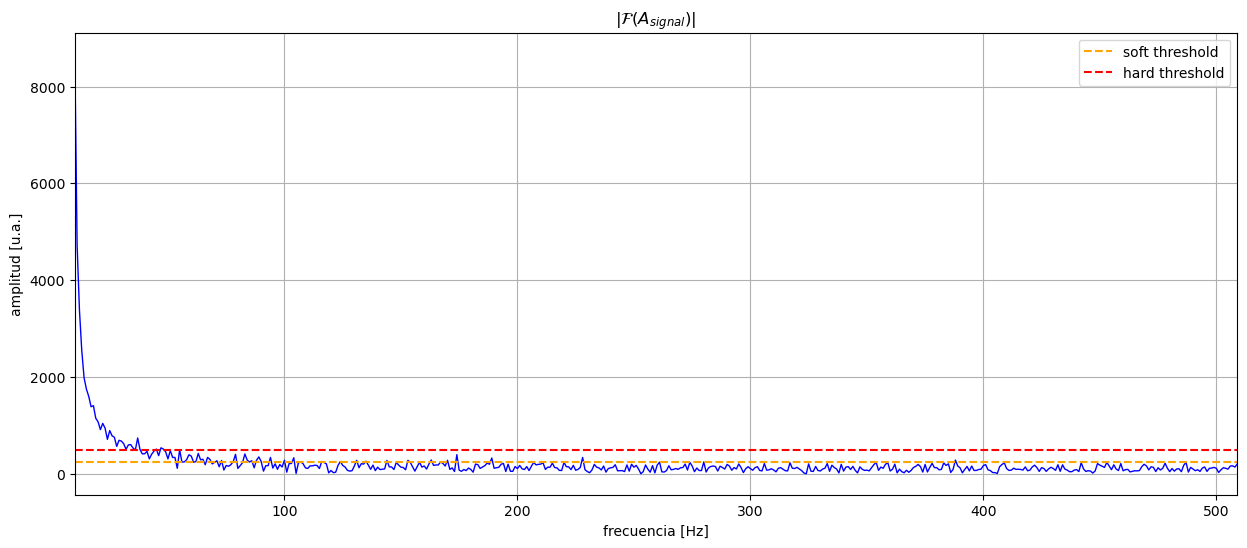

In [260]:
f2_rfft = np.fft.rfft(X[:,1])

n = np.shape(f2_rfft)[0] # np.size(t)
frequencies_rel = n * np.linspace(0,1,int(n))

init, step = 10, 500 
fig=plt.figure(3, figsize=(15,6))
plt.plot(frequencies_rel[init:init+step], np.abs(f2_rfft[init:init+step]), lw=1.0, c='b')
#plt.stem(frequencies_rel, np.abs(f2_rfft))


plt.xlim([np.min(frequencies_rel[init:init+step]), np.max(frequencies_rel[init:init+step])])

plt.axhline(y = 250, color ="orange", linestyle ="--", label='soft threshold')
plt.axhline(y = 500, color ="red", linestyle ="--", label='hard threshold')

plt.xlabel("frecuencia [Hz]")
plt.ylabel("amplitud [u.a.]")
plt.title(r'$|\mathcal{F}(A_{signal})|$')
plt.legend()
plt.grid()

plt.show()

#### Interpretación:
Como podemos ver aquí, en una porción de las frecuencias del espectro de fourier, hay muchas combinaciones de frecuencias, por lo general, queremos eliminar aquellas frecuencias bajas que se asocian con el ruido de nuestra señal. Aquí la estrategia constará de eliminar las frecuencias que estén por debajo del umbral de amplitud = 200 y también, dado que la amplitud de la frecuencia 9Hz es la más alta con diferencia, se ocupará un treshold más agresivo y se eliminaran todas las frecuencias con amplitud < a 500. Ambos resultados se ocuparán para transformar inversamente y recuperar las señales filtradas para posteriormente agregarlas como features a nuestro dataset X.

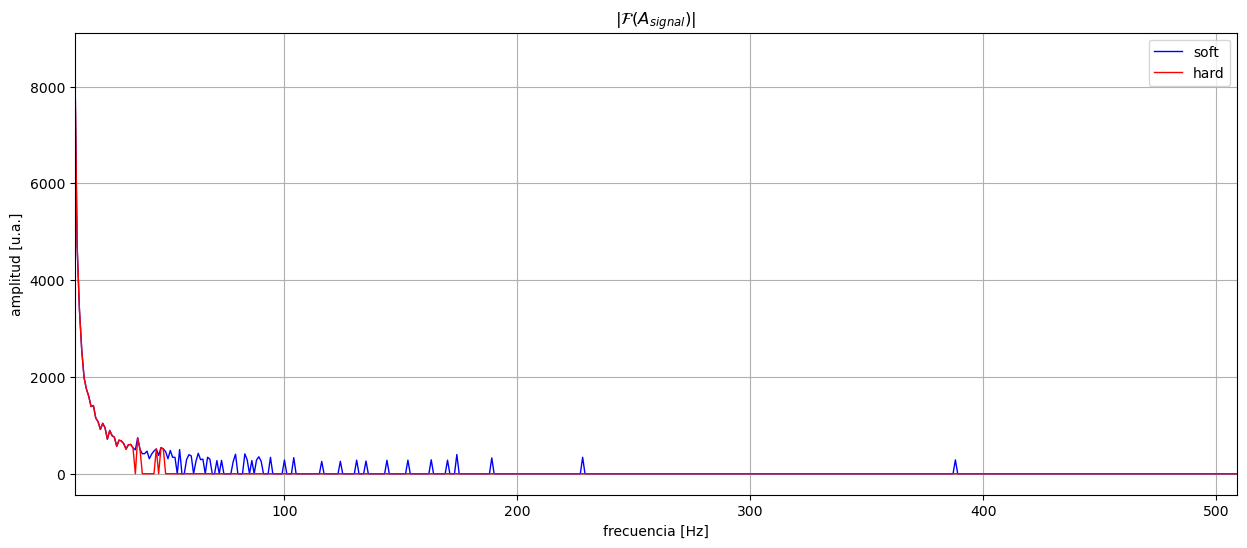

In [261]:
f2_rfft_filtered_hard = np.where(np.abs(f2_rfft) > 500, f2_rfft, 0)
f2_rfft_filtered_soft = np.where(np.abs(f2_rfft) > 250, f2_rfft, 0)

fig=plt.figure(3, figsize=(15,6))
plt.plot(frequencies_rel[init:init+step], np.abs(f2_rfft_filtered_soft[init:init+step]), lw=1.0, c='blue', label='soft')
plt.plot(frequencies_rel[init:init+step], np.abs(f2_rfft_filtered_hard[init:init+step]), lw=1.0, c='red', label='hard')
#plt.stem(frequencies_rel, np.abs(f2_rfft))


plt.xlim([np.min(frequencies_rel[init:init+step]), np.max(frequencies_rel[init:init+step])])

plt.xlabel("frecuencia [Hz]")
plt.ylabel("amplitud [u.a.]")
plt.title(r'$|\mathcal{F}(A_{signal})|$')
plt.legend()
plt.grid()

plt.show()

In [262]:
f2_irfft_filtered_soft = np.fft.irfft(f2_rfft_filtered_soft)
f2_irfft_filtered_hard = np.fft.irfft(f2_rfft_filtered_hard)

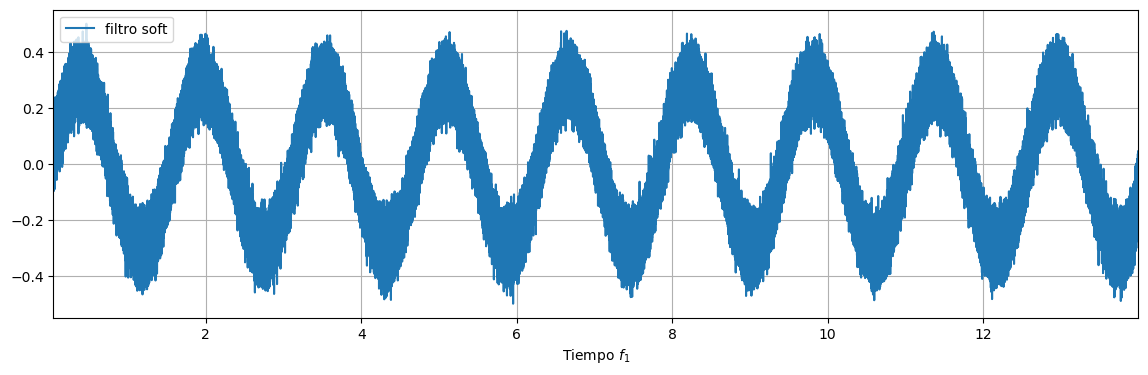

In [263]:
plot_timeSeries(time = X[:,0], signal = f2_irfft_filtered_soft,
                init = 2000, step=f2_irfft_filtered_soft.shape[0],
                labels = [r'Tiempo $f_1$', r'filtro soft'])

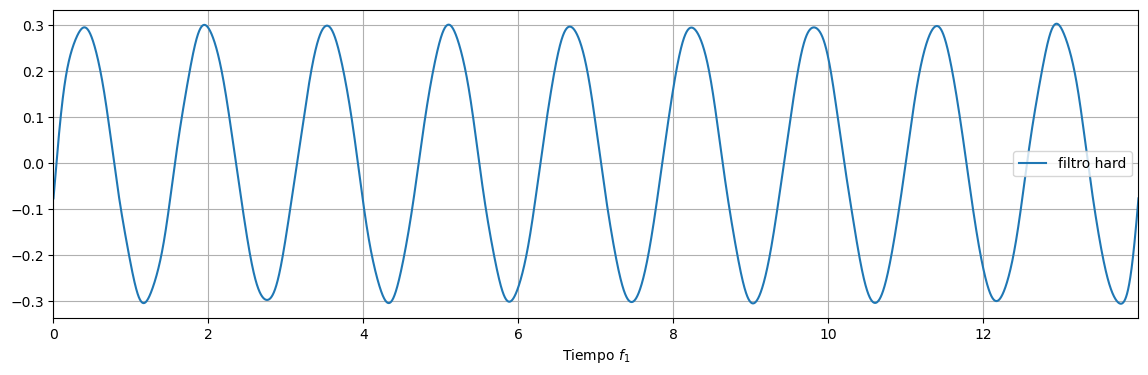

In [264]:
plot_timeSeries(time = X[:,0], signal = f2_irfft_filtered_hard,
                init = 0, step=f2_irfft_filtered_hard.shape[0],
                labels = [r'Tiempo $f_1$', r'filtro hard'])

#### Mismo procedimiento pero para y

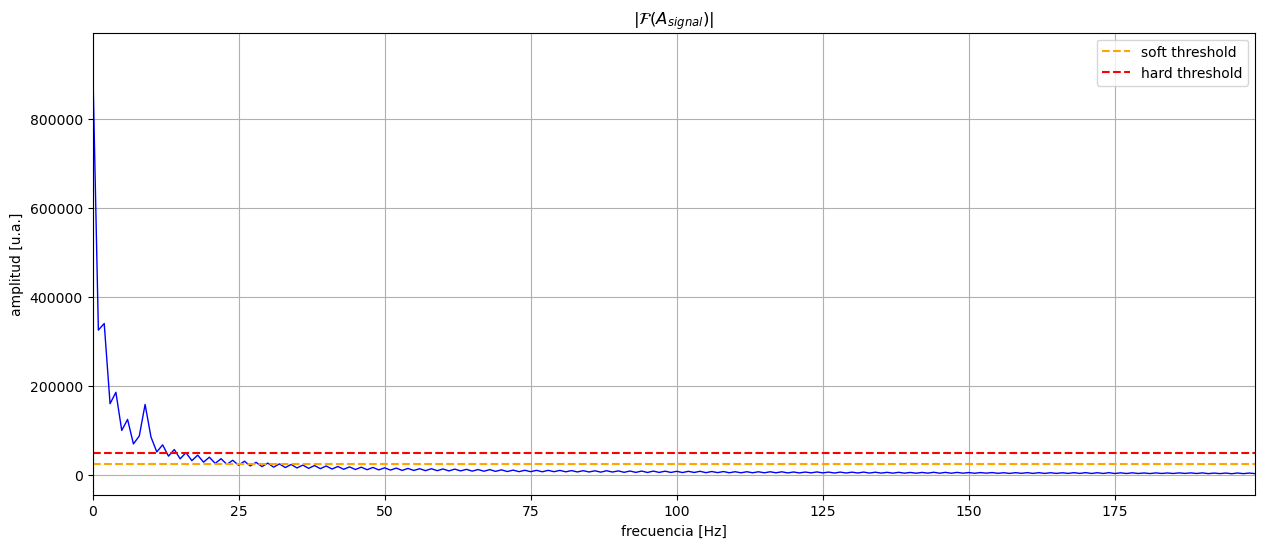

In [239]:
y_rfft = np.fft.rfft(y)

n = np.shape(y_rfft)[0] # np.size(t)
frequencies_rel = n * np.linspace(0,1,int(n))

init, step = 0,200
fig=plt.figure(3, figsize=(15,6))
plt.plot(frequencies_rel[init:init+step], np.abs(y_rfft[init:init+step]), lw=1.0, c='b')
#plt.stem(frequencies_rel, np.abs(y_rfft))


plt.xlim([np.min(frequencies_rel[init:init+step]), np.max(frequencies_rel[init:init+step])])

plt.axhline(y = 1e5/4, color ="orange", linestyle ="--", label='soft threshold')
plt.axhline(y = 1e5/2, color ="red", linestyle ="--", label='hard threshold')

plt.xlabel("frecuencia [Hz]")
plt.ylabel("amplitud [u.a.]")
plt.title(r'$|\mathcal{F}(A_{signal})|$')
plt.legend()
plt.grid()

plt.show()

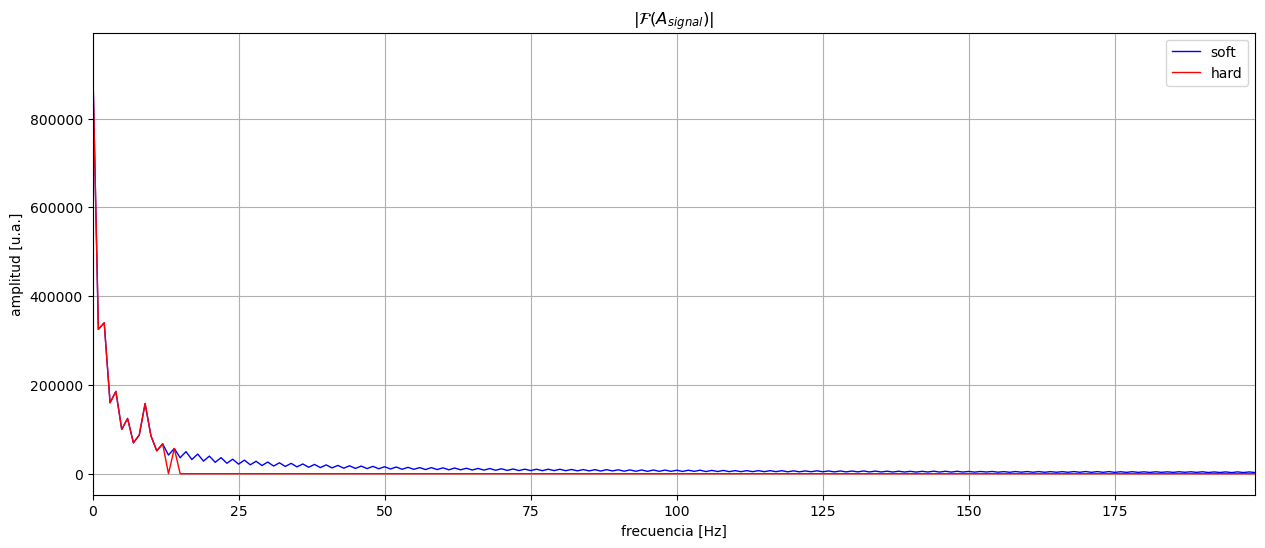

In [240]:
y_rfft_filtered_hard = np.where(np.abs(y_rfft) > 1e5/2, y_rfft, 0)
y_rfft_filtered_soft = np.where(np.abs(y_rfft) > 1e4/4, y_rfft, 0)

fig=plt.figure(3, figsize=(15,6))
plt.plot(frequencies_rel[init:init+step], np.abs(y_rfft_filtered_soft[init:init+step]), lw=1.0, c='blue', label='soft')
plt.plot(frequencies_rel[init:init+step], np.abs(y_rfft_filtered_hard[init:init+step]), lw=1.0, c='red', label='hard')

plt.xlim([np.min(frequencies_rel[init:init+step]), np.max(frequencies_rel[init:init+step])])

plt.xlabel("frecuencia [Hz]")
plt.ylabel("amplitud [u.a.]")
plt.title(r'$|\mathcal{F}(A_{signal})|$')
plt.legend()
plt.grid()

plt.show()

In [241]:
y_irfft_filtered_hard = np.fft.irfft(y_rfft_filtered_hard)
y_irfft_filtered_soft = np.fft.irfft(y_rfft_filtered_soft)

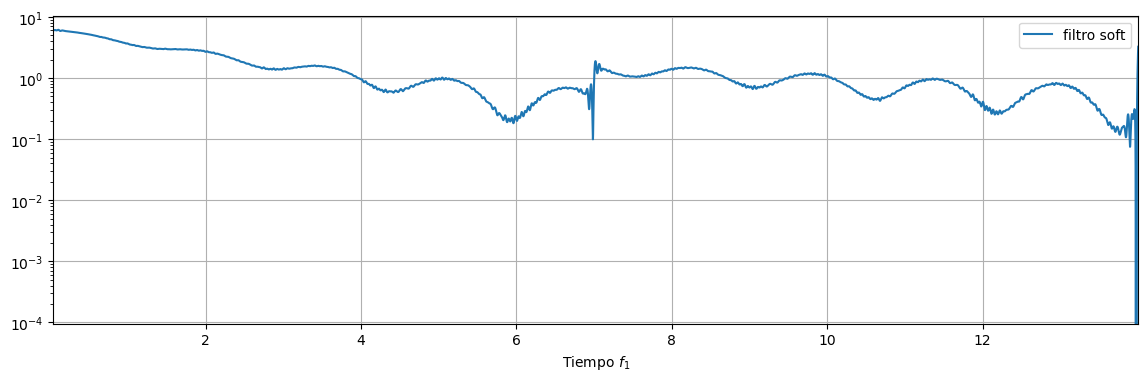

In [253]:
plot_timeSeries(time = X[:,0], signal = y_irfft_filtered_soft,
                init = 2000, step=y_irfft_filtered_soft.shape[0],
                labels = [r'Tiempo $f_1$', r'filtro soft'])

In [254]:
plot_timeSeries(time = X[:,0], signal = y_irfft_filtered_hard,
                init = 2000, step=y_irfft_filtered_hard.shape[0],
                labels = [r'Tiempo $f_1$', r'filtro soft'])

## Exploratory Data Analysis

### Gráfico de f1

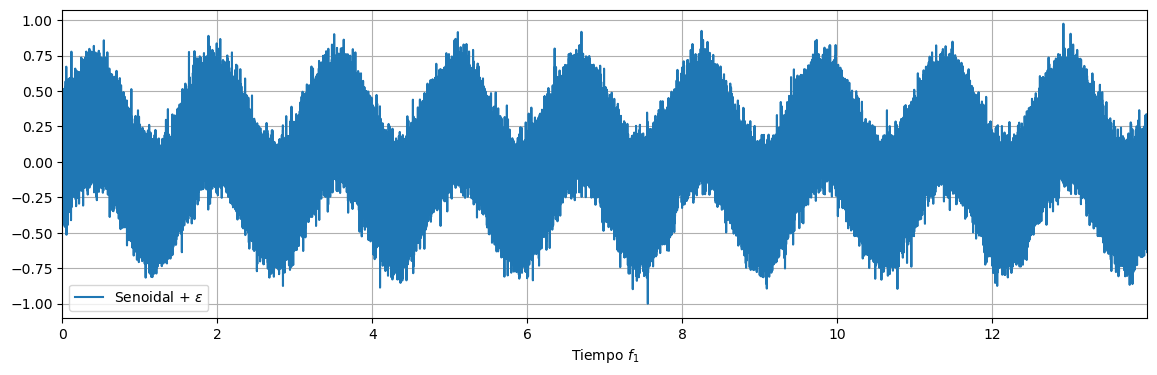

In [102]:
plot_timeSeries(time = X[:,0], signal = X[: ,1],
                init = 0, step=X[: ,1].shape[0],
                labels = [r'Tiempo $f_1$', r'Senoidal + ' + r'$\epsilon$'])

### Gráfico de y 

In [103]:
plot_timeSeries(time = X[:,0], signal = y,
                init = 0, step=y.shape[0],
                labels = [r'Tiempo $f_1$', r'Senoidal + ' + r'Energía detectada'])

### Y luego de la logaritmización

Ahora pareciera tener una forma más lineal, aunque sique habiendo mucho ruido en el extremo izquierdo.

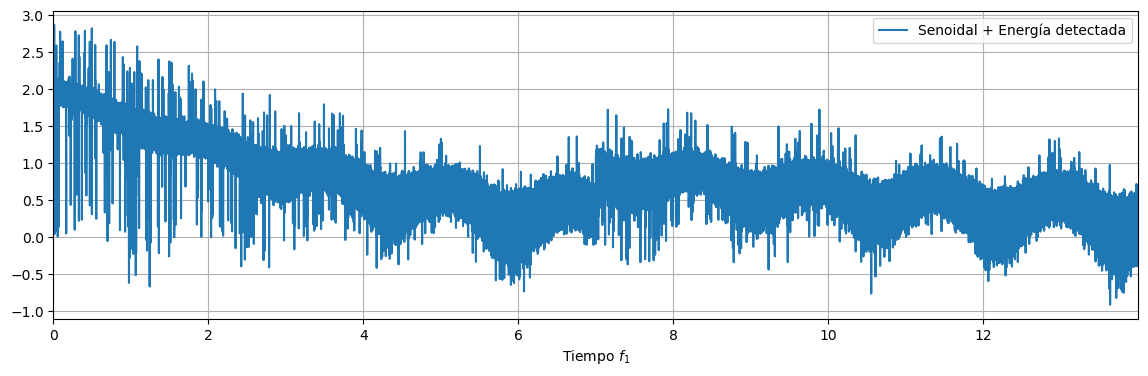

In [104]:
y_log1p = np.log1p(y)
plot_timeSeries(time = X[:,0], signal = y_log1p,
                init = 0, step=y.shape[0],
                labels = [r'Tiempo $f_1$', r'Senoidal + ' + r'Energía detectada'])

### Limpieza de outliers

In [114]:
columns = ['f1', 'f2', 'energia', 'y_log1p']
df['y_log1p'] = y_log1p
df_fil = remove_outliers_iqr(df[columns], cols=columns)

Columna 'f1': Eliminados 0 outliers.
Columna 'f2': Eliminados 87 outliers.
Columna 'energia': Eliminados 84619 outliers.
Columna 'y_log1p': Eliminados 85365 outliers.
(614635, 4)


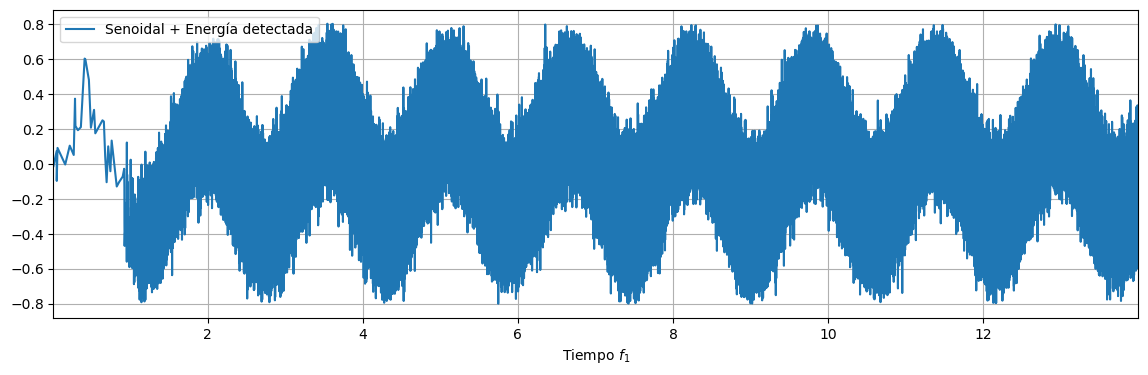

In [118]:
plot_timeSeries(time = df_fil['f1'], signal = df_fil['f2'],
                init = 0, step=y.shape[0],
                labels = [r'Tiempo $f_1$', r'Senoidal + ' + r'Energía detectada'])

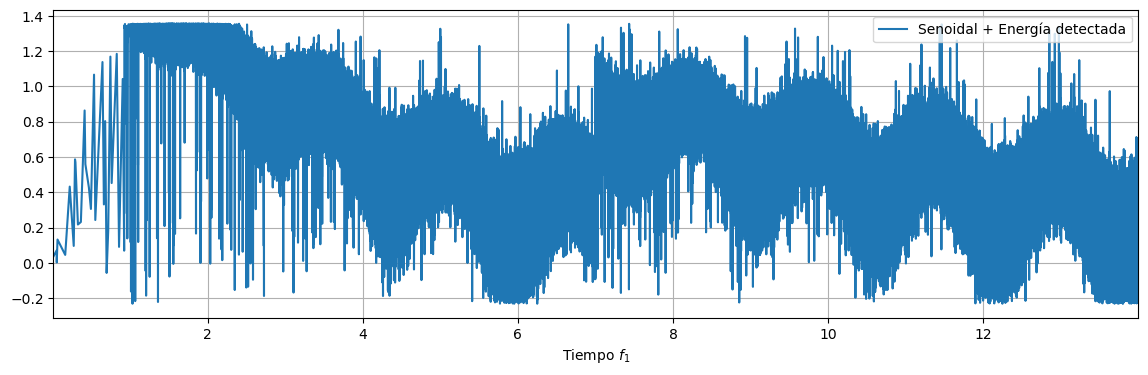

In [117]:
plot_timeSeries(time = df_fil['f1'], signal = df_fil['y_log1p'],
                init = 0, step=y.shape[0],
                labels = [r'Tiempo $f_1$', r'Senoidal + ' + r'Energía detectada'])

## Modelo Polinomial

In [137]:
degree =10
coefficients = np.polyfit(df_fil['f2'], df_fil['y_log1p'], degree)

print(f"Coeficientes del polinomio ajustado (grado {degree}): {coefficients}")

y_fit = np.polyval(coefficients, df_fil['f2'])

Coeficientes del polinomio ajustado (grado 10): [-4.04983496  7.35210194  4.21989337 -7.09834543 -1.34327638  1.62541401
  0.65562684 -0.15521832 -0.32868221  0.51433846  0.64257003]


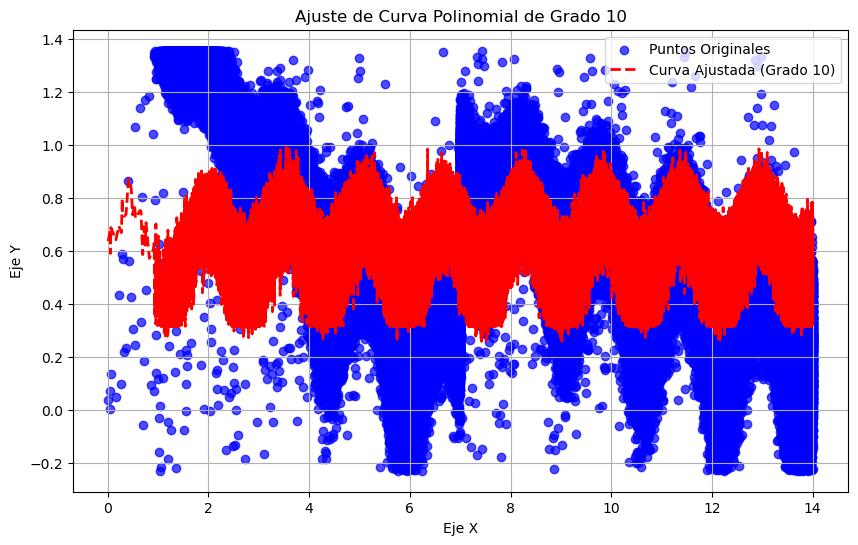

In [138]:
plt.figure(figsize=(10, 6))

plt.scatter(df_fil['f1'], df_fil['y_log1p'], label='Puntos Originales', color='blue', alpha=0.7)

# Curva ajustada
plt.plot(df_fil['f1'], y_fit, label=f'Curva Ajustada (Grado {degree})', color='red', linestyle='--', linewidth=2)

# Añadir título y etiquetas
plt.title(f'Ajuste de Curva Polinomial de Grado {degree}')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
predicciones = pipeline_energy.predict(df_fil[['f1','f2']])

/home/gaara/Documents/USM/2025-01/INF396/tarea2/t2_inf396/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


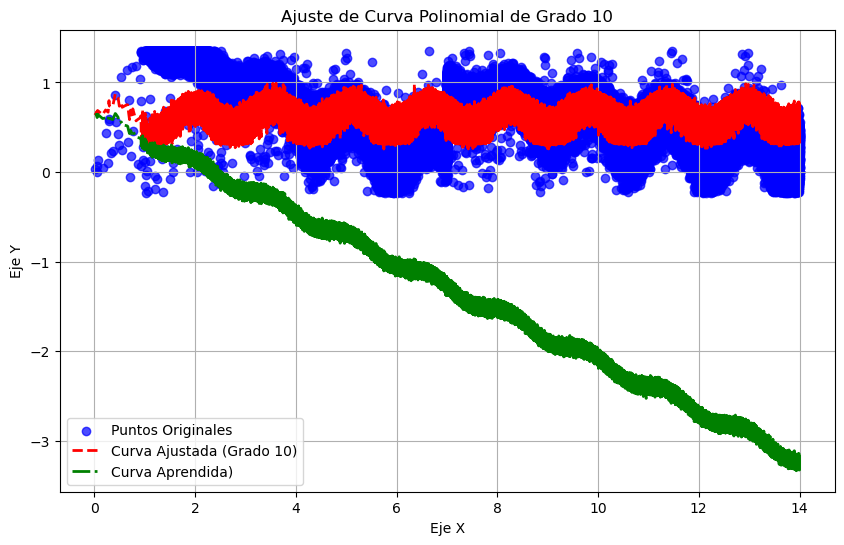

In [145]:
plt.figure(figsize=(10, 6))

plt.scatter(df_fil['f1'], df_fil['y_log1p'], label='Puntos Originales', color='blue', alpha=0.7)

# Curva ajustada
plt.plot(df_fil['f1'], y_fit, label=f'Curva Ajustada (Grado {degree})', color='red', linestyle='--', linewidth=2)
plt.plot(df_fil['f1'], predicciones,label=f'Curva Aprendida)', color='green', linestyle='-.', linewidth=2)

# Añadir título y etiquetas
plt.title(f'Ajuste de Curva Polinomial de Grado {degree}')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.grid(True)
plt.show()

## Modelo Aprendizaje automático

In [146]:
X = df_fil.drop(['y_log1p', 'energia'], axis=1)
y = df_fil['y_log1p']

In [126]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDRegressor(random_state=42, verbose=0)
param_grid = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'learning_rate': ['optimal'],
    'penalty': ['l1','l2', 'elasticnet'],
    'alpha': [1e-3, 1e-2, 1e-1], # Fuerza de regularización
    'max_iter': [1000],
    'tol': [1e-3]
}

cv_kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_kfolds,
    scoring='neg_mean_absolute_error', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [127]:
grid(X_scaled, y, cv_kfolds, grid_search, flag=1)


Realizando búsqueda de hiperparámetros con GridSearchCV...

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDRegressor
Mejor puntuación de ('neg_mean_absolute_error'): -0.1602
Mejores hiperparámetros encontrados: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'huber', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- R2: 0.5019 +/- 0.0012
- Neg Mean Squared Error: -0.0418 +/- 0.0001
- Neg Mean Absolute Error: -0.1602 +/- 0.0003
- Neg Root Mean Squared Error: -0.2044 +/- 0.0002

¡Búsqueda de hiperparámetros y evaluación completadas!


SGDRegressor(alpha=0.001, learning_rate='optimal', loss='huber',
             random_state=42)

In [128]:
pipeline_energy = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', SGDRegressor(
        loss='huber',
        learning_rate='optimal',
        max_iter = 1000,
        penalty='l2',
        tol=1e-3,
        alpha=0.001,
        random_state=42
    ))
])

pipeline_energy.fit(X_scaled, y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf',
                 SGDRegressor(alpha=0.001, learning_rate='optimal',
                              loss='huber', random_state=42))])

In [129]:
joblib.dump(pipeline_energy, 'question2_energy.pkl')

['question2_energy.pkl']

# Question 3: Fraude en transacciones.

## Data Processing

In [3]:
# Visualizando cuáles son las llaves para inicializar el set de entrenamiento.
datasets_train['fraude'].keys()

dict_keys(['X', 'y'])

In [10]:
# Inicializando el set de entrenamiento.
X =  datasets_train["fraude"]['X']
y = datasets_train["fraude"]['y']
X.shape, y.shape

((21000, 11), (21000,))

In [38]:
# Inicialización de un dataframe de pandas para un manejo más cómodo, sobre todo para el EDA.
columns = ['hora', 'monto', 'random31', 
           'pais_CL', 'pais_US', 'pais_CN', 'pais_RU',
           'retail', 'online', 'crypto', 'food']
df = pd.DataFrame(X)
df.columns = columns
df['fraude'] = y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hora      21000 non-null  float32
 1   monto     21000 non-null  float32
 2   random31  21000 non-null  float32
 3   pais_CL   21000 non-null  float32
 4   pais_US   21000 non-null  float32
 5   pais_CN   21000 non-null  float32
 6   pais_RU   21000 non-null  float32
 7   retail    21000 non-null  float32
 8   online    21000 non-null  float32
 9   crypto    21000 non-null  float32
 10  food      21000 non-null  float32
 11  fraude    21000 non-null  int64  
dtypes: float32(11), int64(1)
memory usage: 1.0 MB


In [258]:
df.describe()

hora         monto      random31       pais_CL       pais_US  \
count  21000.000000  21000.000000  21000.000000  21000.000000  21000.000000   
mean      11.521714     33.327305      0.004836      0.603714      0.147286   
std        6.951979     46.306541      1.006699      0.489126      0.354420   
min        0.000000      0.240125     -3.845798      0.000000      0.000000   
25%        5.000000      9.977383     -0.670185      0.000000      0.000000   
50%       11.000000     19.870639      0.004408      1.000000      0.000000   
75%       18.000000     39.515371      0.686109      1.000000      0.000000   
max       23.000000   1948.758545      3.561476      1.000000      1.000000   

            pais_CN       pais_RU        retail        online        crypto  \
count  21000.000000  21000.000000  21000.000000  21000.000000  21000.000000   
mean       0.097762      0.151238      0.251286      0.248857      0.246333   
std        0.296987      0.358293      0.433789      0.432386      0.430937   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               food        fraude  
count  21000.000000  21000.000000  
mean       0.253524      0.001286  
std        0.435012      0.035835  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        1.000000      0.000000  
max        1.000000      1.000000

## Exploratory Data Analysis

In [285]:
def plots_by(df, cat):
    
    df_fil = df[df[cat] == 1.0]

    if cat[:4] != 'pais':
        cols = ['pais_CL', 'pais_US', 'pais_CN', 'pais_RU']
    else:
        cols = ['retail', 'online', 'crypto', 'food']
    
    df_melted = df_fil.melt(id_vars=['monto', 'hora', 'random31', cat],
                        value_vars=cols,
                        var_name='nombre_categoria',
                        value_name='valor_presente')
    
    df_present = df_melted[df_melted['valor_presente'] == 1]
    
    f, axs = plt.subplots(2, 2, figsize=(9, 7), gridspec_kw=dict(width_ratios=[1, 1]))
    
    sns.scatterplot(data=df_fil[df_fil['fraude']==0], x="hora", y="monto", hue="fraude", alpha=0.3, s=30, ax=axs[0,0])
    sns.scatterplot(data=df_fil[df_fil['fraude']==1], x="hora", y="monto", hue="fraude", alpha=1.0, s=60, ax=axs[0,0], palette=['orange'])
    
    sns.histplot(data=df_present, x="nombre_categoria",shrink=.8, alpha=.8, legend=False, ax=axs[0,1])

    sns.histplot(data=df_fil['monto'], kde=True, shrink=.8, alpha=.8, legend=False, ax=axs[1,0])

    sns.histplot(data=df_fil['hora'], kde=True, shrink=.8, alpha=.8, legend=False, ax=axs[1,1])
    
    f.tight_layout()
    plt.show()

def clustermap(df, cat):
    df_fil = df[df[cat] == 1.0]

    if cat[:4] != 'pais':
        cols = ['pais_CL', 'pais_US', 'pais_CN', 'pais_RU']
    else:
        cols = ['retail', 'online', 'crypto', 'food']
        
    final_cols = [col for col in (['monto', 'hora'] + cols) if df_fil[col].std() != 0]
    
    sns.clustermap(df_fil[final_cols],
                   metric="correlation",
                   figsize=(6, 6))
    

### Heatmap de correlación con todo el dataset. (Sólo fraudes)

Análisis: Dado que los fraudes son muy reducidos en este dataset, vale la pena ver qué características se correlacionan en esta categoría.
Podemos ver que hay una tendencia positiva entre el monto gastado y las features país_RU y retail. También hay una fuerte relación entre la hora y la comida. Por otro lado, las correlaciones negativas podemos ver que se encuentra el monto con cryptos.

<Axes: >

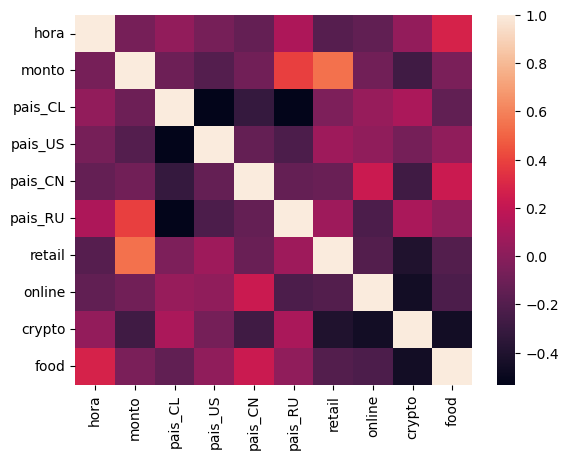

In [321]:
corr_cols = ['hora', 'monto', 'pais_CL', 'pais_US', 'pais_CN', 'pais_RU',
       'retail', 'online', 'crypto', 'food']
df_fil = df[df['fraude']==1]
df_corr = df_fil[corr_cols].corr()

sns.heatmap(df_corr)

## Visualización por países.

### Hora y Monto en Pais_CL

Análisis: Podemos ver una cantidad no menor de fraudes, lo que llama la atención es que rondan las 150 unidades monetarias. Del mismo modo, podemos ver una que la mayor cantidad de fraudes se centra en las 17 hrs. Respecto a otros datos, vemos que la mayoría de compras no superar las 250 unidades monetarias, lo cual dificulta la detección de fraudes puesto que se mimetizan con transacciones legítimas. también, se puede ver que en general la cantidad de compras en las diferentes tiendas en pais_CL está bastante balanceada. Finalmente, lo último que podemos analizar es que hay horas que presentan picos de actividad. 

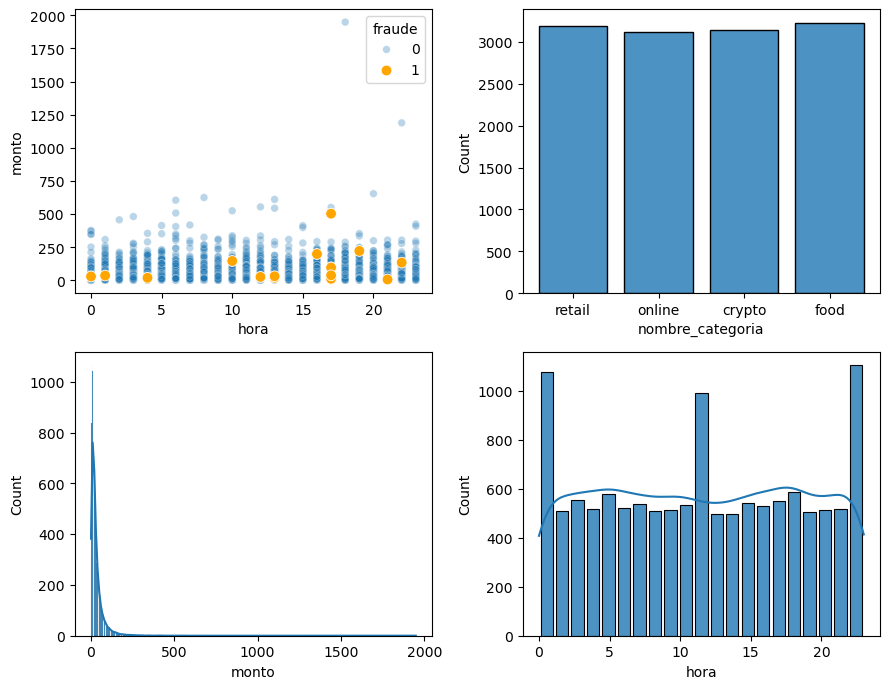

In [298]:
cat='pais_CL'
plots_by(df, cat)

Análisis: Por otro lado, el cluster map de los fraudes resalta únicamente el monto de las compras.

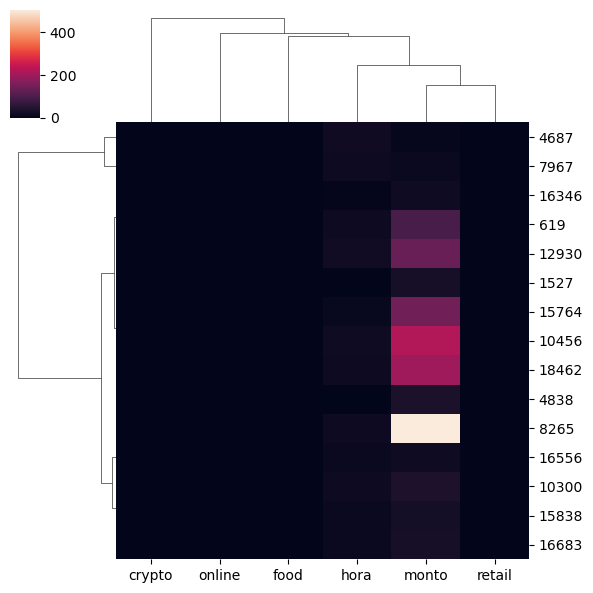

In [299]:
clustermap(df[df['fraude']==1], cat)

### Hora y monto en pais_US

Análisis: Esta vez tenemos menos fraudes respecto a pais_CL. No obstante, vemos diferencias significativas en cuanto a la distribución del monto, donde los valores están más concentrados y no hay variaciones atípicas. Por otro lado, la distribución de interacciones por retail parece ser equitativa. Finalmente, en cuanto a las distribuciones por hora, podemos ver que hay un flujo más constante de actividad respecto a pais_CL pero, eso sí, siendo considerablemente menos gente en general.

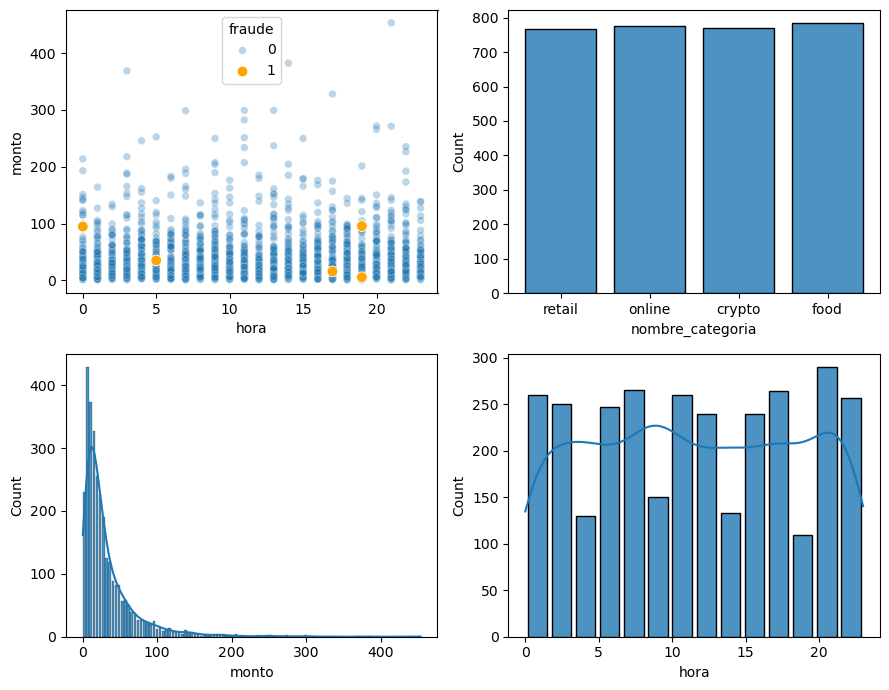

In [300]:
cat='pais_US'
plots_by(df, cat)

Análisis: aquí se puede ver una mayor diversidad en torno a los valores clusterizados mediante jerarquía. Se pueden ver valores de montos al rededor de 100 que se agrupan mientras. También se ve que la hora toma presencia en estte diagrama.

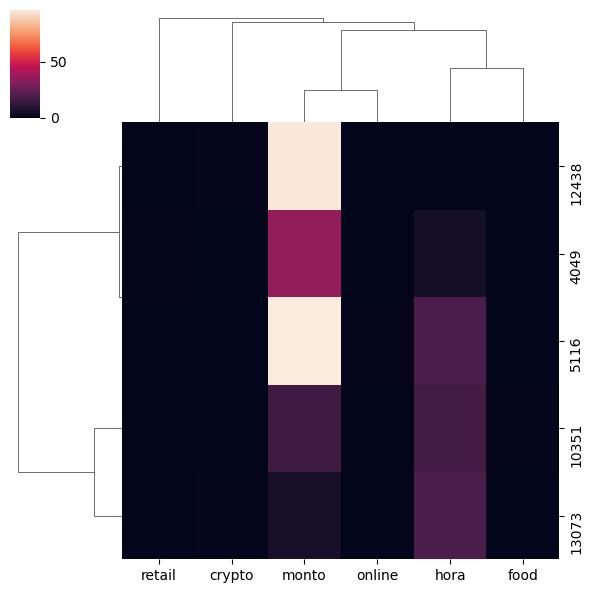

In [301]:
clustermap(df[df['fraude']==1], cat)

### Hora y monto en pais_CN

Análisis: Aqui se pueden ver considerablemente menos fraudes, al mismo tiempo que valores mucho más variables respecto al monto de compra. El patrón de horas y de tipo de comercio se mantiene relativamente similar a los ya observados.

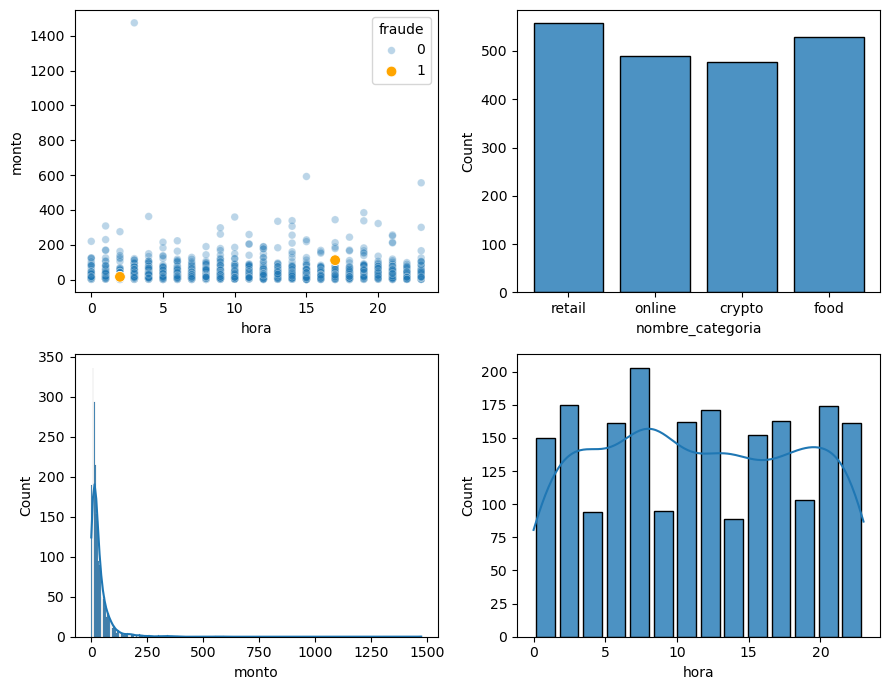

In [302]:
cat='pais_CN'
plots_by(df, cat)

In [ ]:
Análisis: Al parecer no hay muchas fratures relevantes en esta ocasión, lo que más determina la clusterización es le monto y ligeramente la hora.

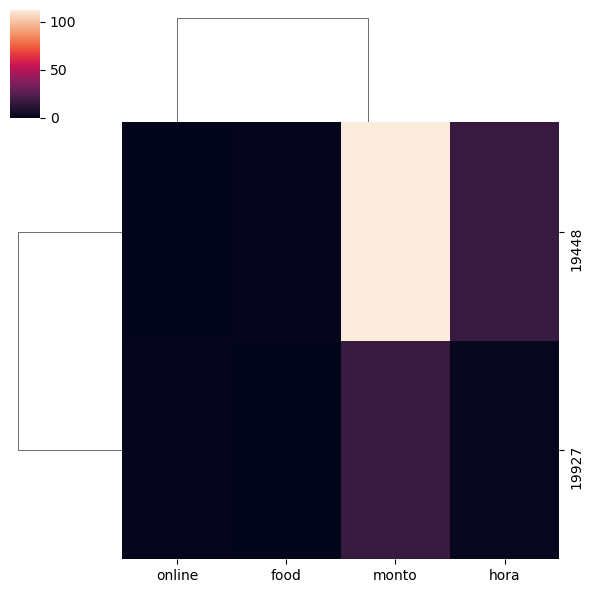

In [303]:
clustermap(df[df['fraude']==1], cat)

### Hora y monto en pais_RU

Análisis: Muy pocos fraudes, 2 para ser exacto, se rompe con la uniformidad que estabamos viendo en los tipos de comercio y al parecer se nota mucho más concentrado y cecanos a 0 los montos gastados en unidades monetarias.

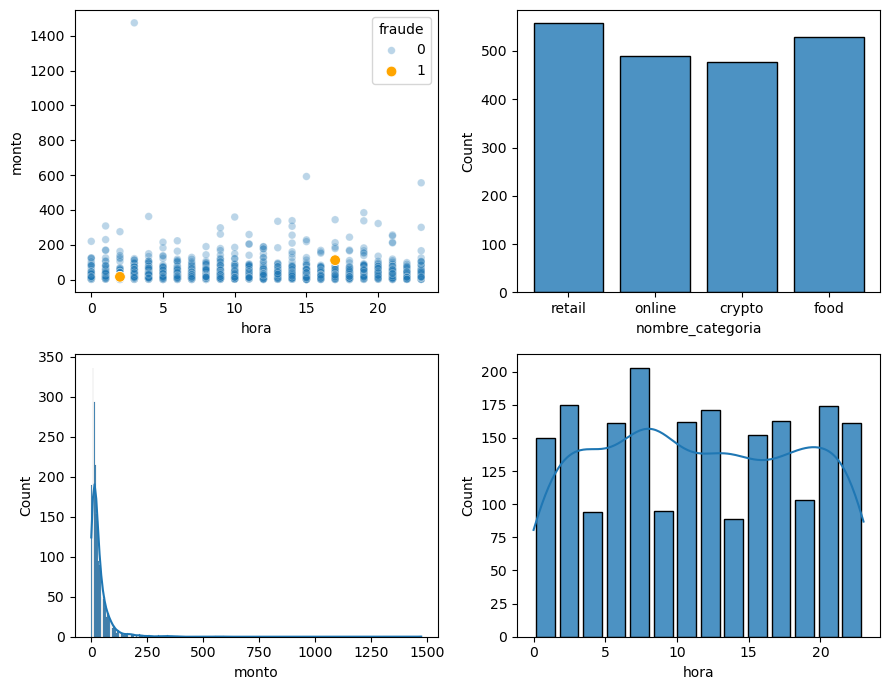

In [304]:
cat=='pais_RU'
plots_by(df, cat)

Análisis: Nada nuevo, monto y hora prevalecen y se destaca el monto gastado que ronda las 100 unidades monetarias.

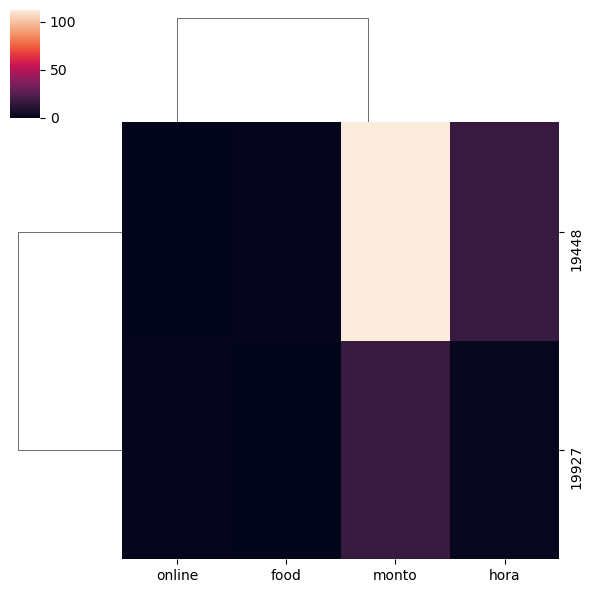

In [305]:
clustermap(df[df['fraude']==1], cat)

## Visualización por tipo de comercio:

### Tipo retail

Análisis: Se puede apreciar que el 50\% de los valores catalogados como fraude son muy altos en este tipo de comercio, rondando las casi 800 y 550 unidades monetarias, a priori, aquí se puede identificar bien cuáles son 

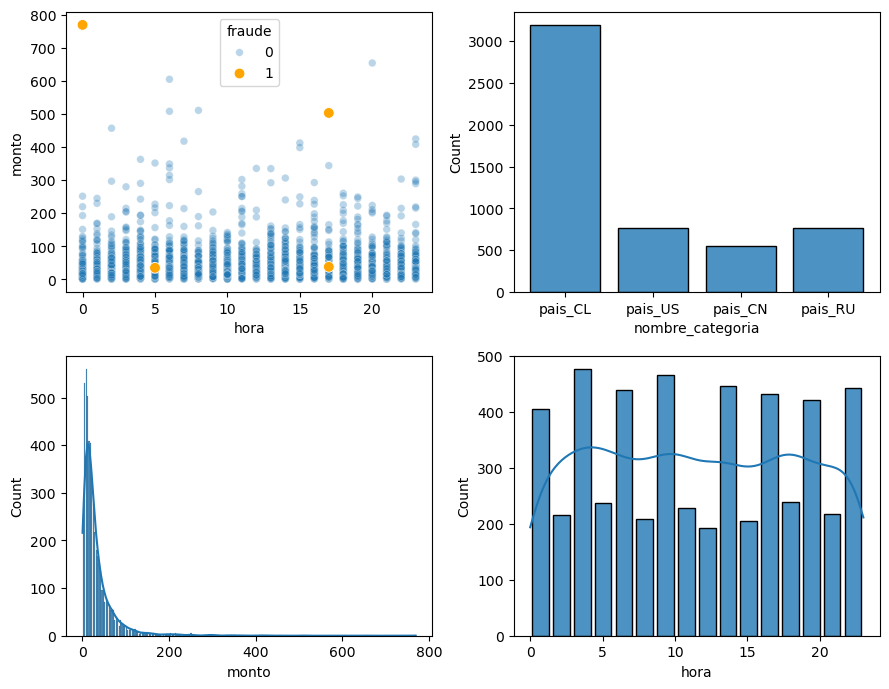

In [221]:
plots_by(df, cat='retail')

Análisi: Al parecer sólo toma como importancia el monto, aquí he de decir que sí tiene sentido sobre todo.

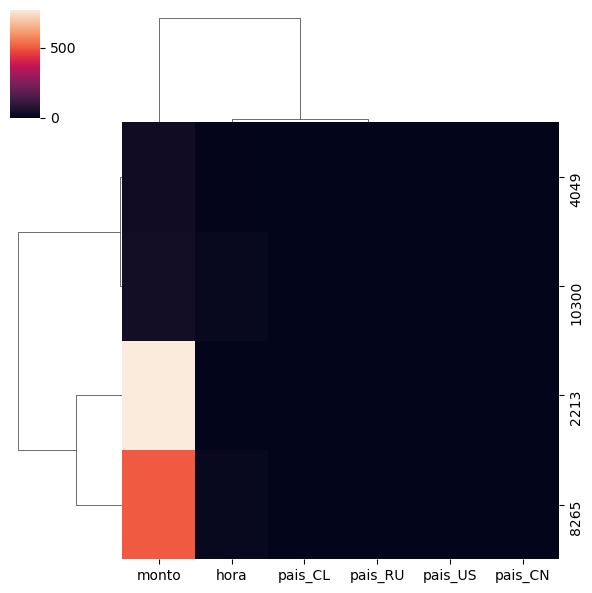

In [250]:
heatmap(df[df['fraude']==1], cat='retail')

### Tipo Online

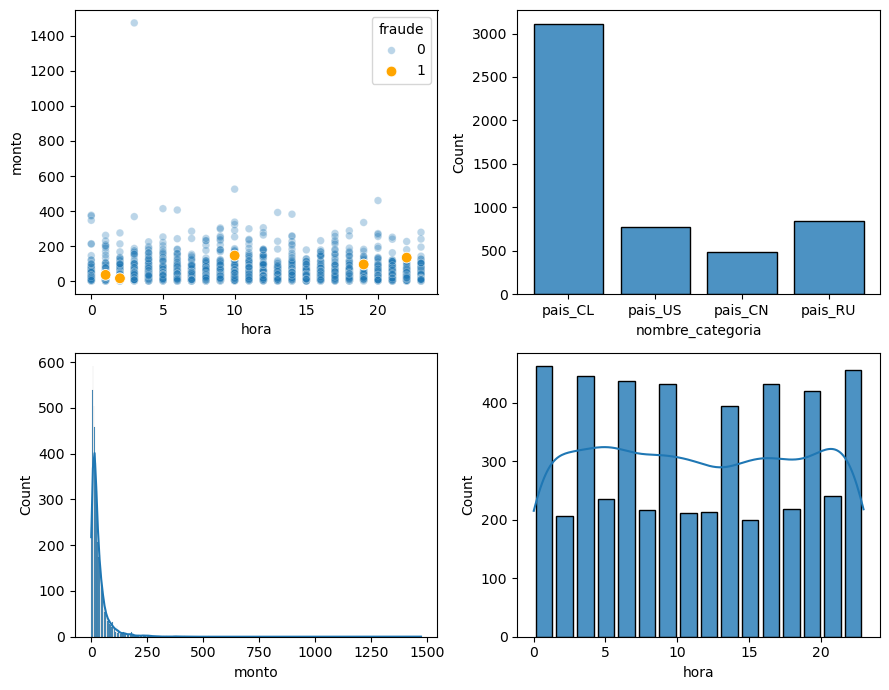

In [286]:
cat='online'
plots_by(df, cat)

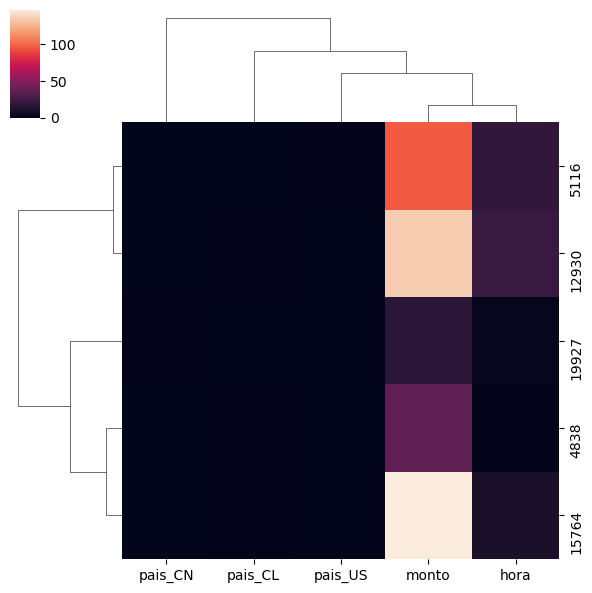

In [287]:
clustermap(df[df['fraude']==1], cat)

### Hora y monto en crypto

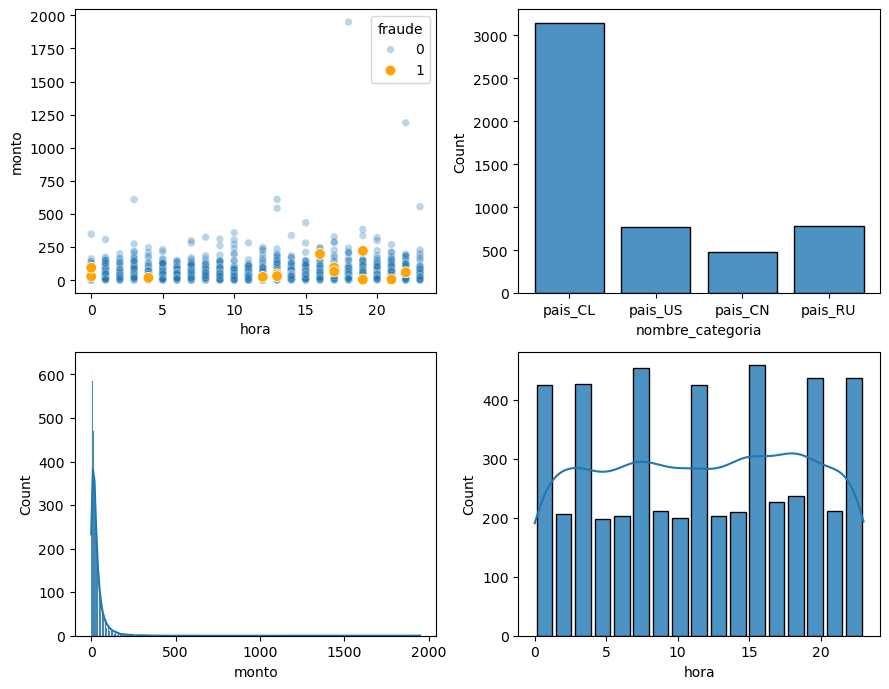

In [288]:
cat='crypto'
plots_by(df, cat)

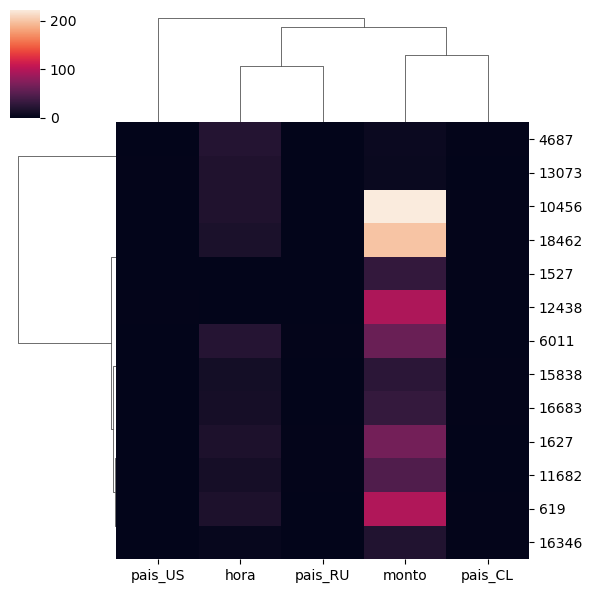

In [289]:
clustermap(df[df['fraude']==1], cat)

### Hora y monto en Food

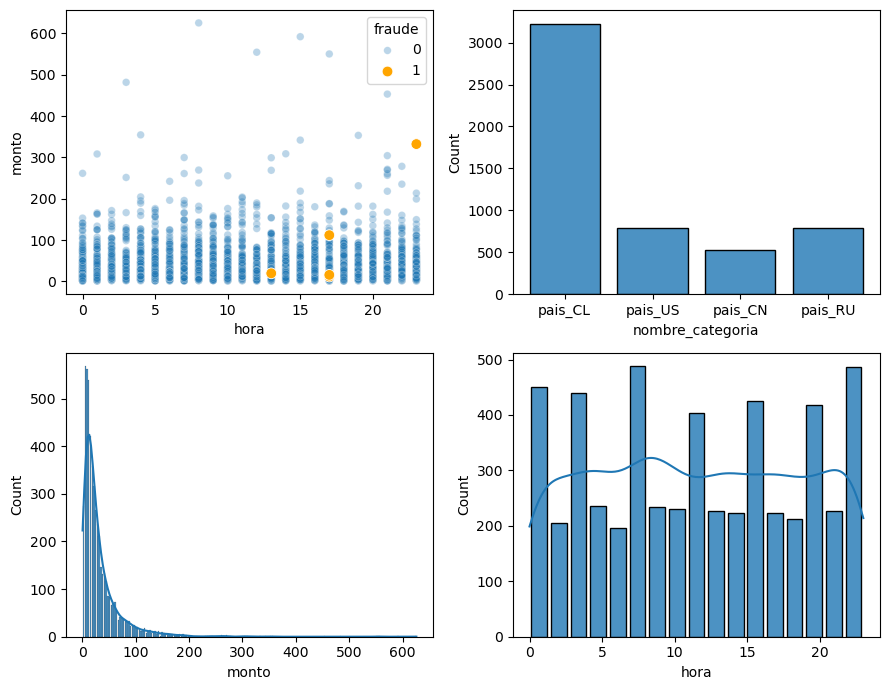

In [295]:
cat='food'
plots_by(df, cat)

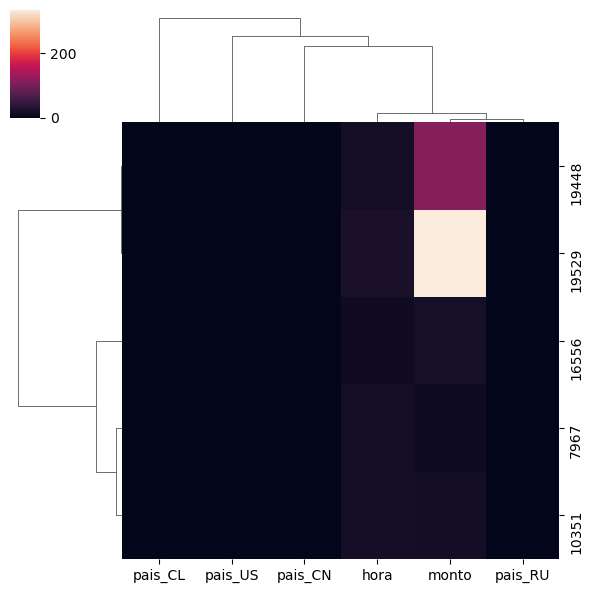

In [297]:
clustermap(df[df['fraude']==1], cat)

## Modelamiento

In [419]:
#Denifir
X = df.drop('fraude', axis=1)
y = df['fraude']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDClassifier(random_state=42, class_weight='balanced', verbose=0)
param_grid = {
    'loss': ['log_loss'],
    'penalty': ['l2', 'elasticnet'],
    'alpha': [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3, 1e4, 1e5], # Fuerza de regularización
    'max_iter': [1000, 10000, 50000, 100000],
    'tol': [1e-4, 1e-3]
}
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_stratified,
    scoring='f1', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [420]:
#Fitear
best_model = grid(X_scaled, y, cv_stratified, grid_search)


Realizando búsqueda de hiperparámetros con GridSearchCV...


/home/gaara/Documents/USM/2025-01/INF396/tarea2/t2_inf396/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gaara/Documents/USM/2025-01/INF396/tarea2/t2_inf396/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gaara/Documents/USM/2025-01/INF396/tarea2/t2_inf396/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gaara/Documents/USM/2025-01/INF396/tarea2/t2_inf396/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximu


Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDClassifier
Mejor puntuación de 'f1' (F1 Score): 0.0265
Mejores hiperparámetros encontrados: {'alpha': 10.0, 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'l2', 'tol': 1e-05}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- Recall: 0.2733 +/- 0.3726
- Precision: 0.0197 +/- 0.0357
- F1 Score: 0.0265 +/- 0.0458
- Roc Auc: 0.7453 +/- 0.1291
- Accuracy: 0.7888 +/- 0.3940

¡Búsqueda de hiperparámetros y evaluación completadas!



Métricas de Rendimiento (sobre conjunto de ENTRENAMIENTO completo):
- Recall: 1.0000
- Precision: 0.0471
- F1-Score: 0.0899
- ROC AUC: 0.9850
- Accuracy: 0.9578


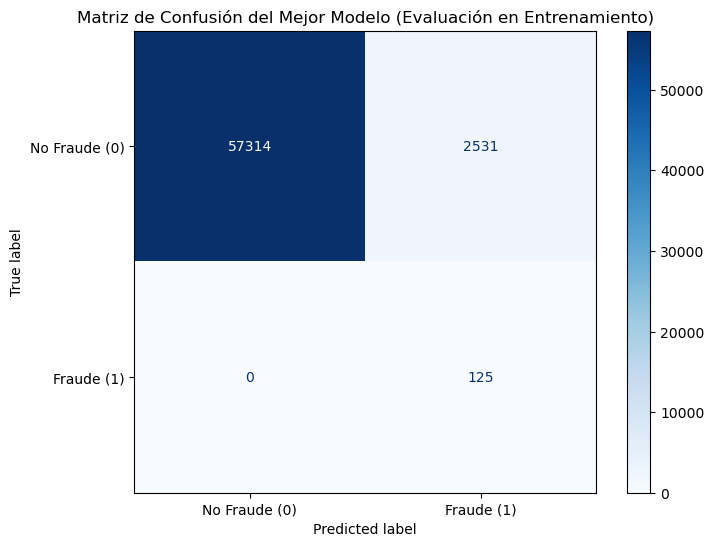

In [203]:
conf_matrix(best_model, cats = ['No Fraude', 'Fraude'])

## Pipeline y modelo:

In [436]:
pipeline_fraude = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(
        loss='log_loss',
        penalty='l2',
        class_weight='balanced',
        max_iter=1000,
        tol=1e-5,
        alpha=10.0,
        random_state=42
    ))
])

pipeline_fraude.fit(X_scaled, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SGDClassifier(alpha=10.0, class_weight='balanced',
                               loss='log_loss', random_state=42, tol=1e-05))])

In [437]:
joblib.dump(pipeline_fraude, 'question3_fraude.pkl')

['question3_fraude.pkl']

# Question 4: Dinámica de Fluidos

## Data processing

In [6]:
# Visualizando cuáles son las llaves para inicializar el set de entrenamiento.
datasets_train['dinamica_fluidos'].keys()

dict_keys(['X', 'y'])

In [7]:
# Inicializando el set de entrenamiento.
X =  datasets_train["dinamica_fluidos"]['X']
y = datasets_train["dinamica_fluidos"]['y']
X.shape, y.shape

((650000, 3), (650000,))

In [8]:
# Inicialización de un dataframe de pandas para un manejo más cómodo, sobre todo para el EDA.
columns = ['f1', # Presión de entrada [atm].
           'f2', # Diámetro de la tubería [m].
           'f3'] # Viscosidad dinámica del fluido [Pa·s].

df = pd.DataFrame(X)
df.columns = columns
df['velocidad'] = y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   f1         650000 non-null  float64
 1   f2         650000 non-null  float64
 2   f3         650000 non-null  float64
 3   velocidad  650000 non-null  float64
dtypes: float64(4)
memory usage: 19.8 MB


In [9]:
df.describe()

f1             f2             f3      velocidad
count  650000.000000  650000.000000  650000.000000  650000.000000
mean        5.499620       0.255291       0.104996       0.942026
std         2.600855       0.141465       0.054877       1.703640
min        -4.986975       0.000000       0.010000      -5.088240
25%         3.249540       0.132683       0.057402       0.106971
50%         5.503023       0.255327       0.104956       0.391972
75%         7.749732       0.377961       0.152539       1.062194
max         9.999983       0.499999       0.200000      29.272948

### Remover Valores No Físicos

Según lo investigado:
* f1 siendo Presión de entrada \[atm\], no puede presentar valores negativos.
* f2 siendo Diámetro de la tubería \[m\], tampoco puede ser negativo ni tampoco 0.
* f3 siendo Viscosidad dinámica del fluido \[Pa·s\], el mínimo de 0.01 correspondería a un superfluido, pero está dentro de lo teóricamente posible.

In [10]:
mask = (df['f1'] >= 0) & (df['f2'] > 0)

df_fil = df[mask]


print(df.shape,df_fil.shape)

(650000, 4) (649748, 4)


### Remover outliers

In [12]:
df_fil = remove_outliers_iqr(df_fil, cols=['f1', 'f2', 'f3', 'velocidad'])

Columna 'f1': Eliminados 0 outliers.
Columna 'f2': Eliminados 0 outliers.
Columna 'f3': Eliminados 0 outliers.
Columna 'velocidad': Eliminados 57092 outliers.
(592656, 4)


## Exploratory Data Analysis 
después de outliers y eliminación de valores no físicos:

### Violin Plots

Análisis: Luego de limpiar los outliers el panorama se aclara bastante. Podemos evidenciar distribuciones muy uniformes a excepción de la feature de velociad. En general la que más rango de valores toma es la feature f1 que va de 0 a 10, seguido de la feature de velocidad de 0 a 2.5 no teniendo valores tan atípicos como se podía evidenciar antes. No obstante, no se puede obtener mucha más información de este plot.

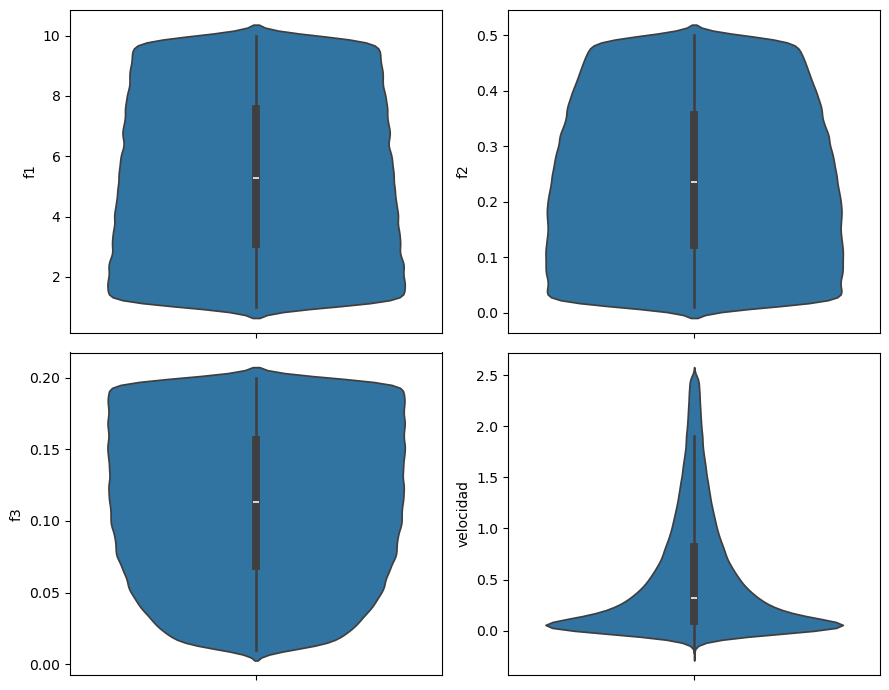

In [13]:
f, axs = plt.subplots(2, 2, figsize=(9, 7), gridspec_kw=dict(width_ratios=[1, 1]))

sns.violinplot(data=df_fil['f1'], ax=axs[0,0])
sns.violinplot(data=df_fil['f2'], ax=axs[0,1])
sns.violinplot(data=df_fil['f3'], ax=axs[1,0])
sns.violinplot(data=df_fil['velocidad'], ax=axs[1,1])


f.tight_layout()
plt.show()

### Feature vs  Feature y distribución:

Análisis: En general los subplots feature vs feature no dan nociones claras de una posible correlación al tratarse de muchos valores. Lo que sí se puede apreciar bastante bien son las distribuciones de cada feature, siendo la distribución de f1 bastante similar a una uniforme, mientras que f2 y f3 presentan formas de decaimiento y crecimiento logarítmico respectivamente. Por último el gráfico de distribución más interesante es el de las velocidades, en donde se podría apreciar una distribución gamma con un evidente sesgo a la derecha y con una moda muy definida.

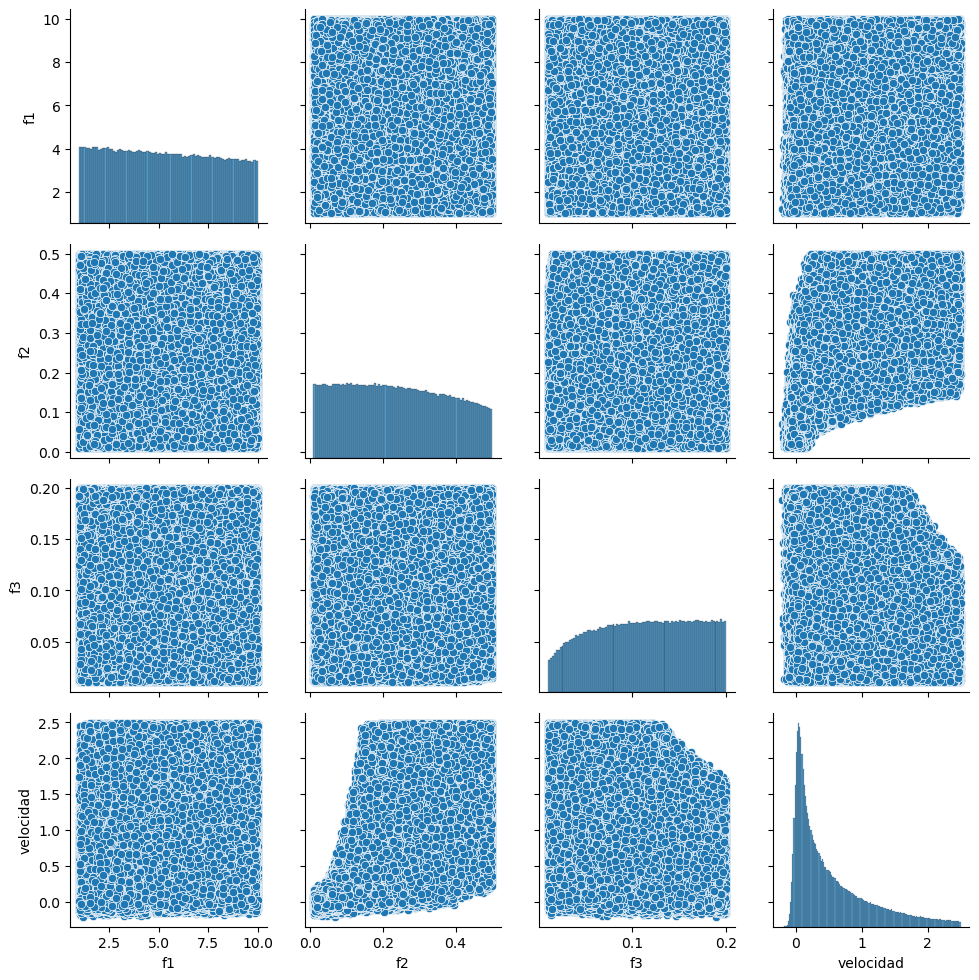

In [14]:
g = sns.PairGrid(df_fil)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

### Heatmap

Análisis: 

In [ ]:
corr_cols = columns + ['velocidad']
#df_fil = df[df['falla']==1]
df_corr = df_fil[corr_cols].corr()

sns.heatmap(df_corr)

## Modelo

In [284]:
X = df_fil.drop('velocidad', axis=1)
y = df_fil['velocidad']

### Con PowerTransformer

In [287]:
scaler = PowerTransformer()
X_scaled = scaler.fit_transform(X)

model_base = SGDRegressor(random_state=42, verbose=0)
param_grid = {
    'loss': ['squared_error'],
    'learning_rate': ['adaptive', 'optimal'],
    'penalty': ['l1','l2', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e1], # Fuerza de regularización
    'max_iter': [1000, 10000, 50000, 100000],
    'tol': [1e-3]
}

cv_kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_kfolds,
    scoring='neg_mean_absolute_error', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [41]:
grid(X_scaled, y, cv_kfolds, grid_search, flag=1)


Realizando búsqueda de hiperparámetros con GridSearchCV...

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDRegressor
Mejor puntuación de ('neg_mean_absolute_error'): -0.2315
Mejores hiperparámetros encontrados: {'alpha': 0.1, 'learning_rate': 'optimal', 'loss': 'squared_error', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- R2: 0.7181 +/- 0.0009
- Neg Mean Squared Error: -0.0957 +/- 0.0008
- Neg Mean Absolute Error: -0.2315 +/- 0.0008
- Neg Root Mean Squared Error: -0.3093 +/- 0.0012

¡Búsqueda de hiperparámetros y evaluación completadas!


SGDRegressor(alpha=0.1, learning_rate='optimal', random_state=42)

### Con MinMaxScaler

In [43]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDRegressor(random_state=42, verbose=0)
param_grid = {
    'loss': ['squared_error'],
    'learning_rate': ['adaptive', 'optimal'],
    'penalty': ['l1','l2', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e1], # Fuerza de regularización
    'max_iter': [1000, 10000, 50000, 100000],
    'tol': [1e-3]
}

cv_kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_kfolds,
    scoring='neg_mean_absolute_error', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=0 # Para ver el progreso de la búsqueda
)

In [44]:
grid(X_scaled, y, cv_kfolds, grid_search, flag=1)


Realizando búsqueda de hiperparámetros con GridSearchCV...

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDRegressor
Mejor puntuación de ('neg_mean_absolute_error'): -0.2265
Mejores hiperparámetros encontrados: {'alpha': 0.01, 'learning_rate': 'optimal', 'loss': 'squared_error', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- R2: 0.7198 +/- 0.0011
- Neg Mean Squared Error: -0.0951 +/- 0.0009
- Neg Mean Absolute Error: -0.2265 +/- 0.0007
- Neg Root Mean Squared Error: -0.3083 +/- 0.0014

¡Búsqueda de hiperparámetros y evaluación completadas!


SGDRegressor(alpha=0.01, learning_rate='optimal', penalty='l1', random_state=42)

## Pipeline y modelo:

Dado que la variante con MinMaxScaler obtuvo mejores resultados:

In [49]:
pipeline_fluidos = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SGDRegressor(
        loss='squared_error',
        learning_rate='optimal',
        max_iter = 1000,
        penalty='l1',
        tol=1e-3,
        alpha=0.01,
        random_state=42
    ))
])

pipeline_fluidos.fit(X_scaled, y)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 SGDRegressor(alpha=0.01, learning_rate='optimal', penalty='l1',
                              random_state=42))])

In [51]:
joblib.dump(pipeline_fluidos, 'question4_fluidos.pkl')

['question4_fluidos.pkl']

# Question 5: Fallas en maquinaria

## Data Processing

In [189]:
# Visualizando cuáles son las llaves para inicializar el set de entrenamiento.
datasets_train['fallas_maquinaria'].keys()

dict_keys(['X', 'y'])

In [190]:
# Inicializando el set de entrenamiento.
X =  datasets_train["fallas_maquinaria"]['X']
y = datasets_train["fallas_maquinaria"]['y']
X.shape, y.shape

((59970, 15), (59970,))

In [191]:
# Inicialización de un dataframe de pandas para un manejo más cómodo, sobre todo para el EDA.

columns = ['vibracion_mean', 'vibracion_std', 'vibracion_max', 'vibracion_min', 'vibracion_fft_energy',
        'temperatura_mean', 'temperatura_std', 'temperatura_max', 'temperatura_min', 'temperatura_fft_energy',
        'corriente_mean', 'corriente_std', 'corriente_max', 'corriente_min', 'corriente_fft_energy']

df = pd.DataFrame(X)
df.columns = columns
df['falla'] = y
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59970 entries, 0 to 59969
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vibracion_mean          59970 non-null  float64
 1   vibracion_std           59970 non-null  float64
 2   vibracion_max           59970 non-null  float64
 3   vibracion_min           59970 non-null  float64
 4   vibracion_fft_energy    59970 non-null  float64
 5   temperatura_mean        59970 non-null  float64
 6   temperatura_std         59970 non-null  float64
 7   temperatura_max         59970 non-null  float64
 8   temperatura_min         59970 non-null  float64
 9   temperatura_fft_energy  59970 non-null  float64
 10  corriente_mean          59970 non-null  float64
 11  corriente_std           59970 non-null  float64
 12  corriente_max           59970 non-null  float64
 13  corriente_min           59970 non-null  float64
 14  corriente_fft_energy    59970 non-null

In [192]:
df_fil=df.copy()

In [183]:
df['falla'].value_counts()

falla
0    59845
1      125
Name: count, dtype: int64

In [184]:
df_fil = pd.concat([remove_outliers_iqr(df[df['falla']==0], cols=columns), remove_outliers_iqr(df[df['falla']==1], cols=columns)], ignore_index=True)

Columna 'vibracion_mean': Eliminados 7143 outliers.
Columna 'vibracion_std': Eliminados 7474 outliers.
Columna 'vibracion_max': Eliminados 7726 outliers.
Columna 'vibracion_min': Eliminados 8794 outliers.
Columna 'vibracion_fft_energy': Eliminados 8908 outliers.
Columna 'temperatura_mean': Eliminados 10073 outliers.
Columna 'temperatura_std': Eliminados 10458 outliers.
Columna 'temperatura_max': Eliminados 10665 outliers.
Columna 'temperatura_min': Eliminados 11566 outliers.
Columna 'temperatura_fft_energy': Eliminados 11573 outliers.
Columna 'corriente_mean': Eliminados 11791 outliers.
Columna 'corriente_std': Eliminados 12328 outliers.
Columna 'corriente_max': Eliminados 12433 outliers.
Columna 'corriente_min': Eliminados 12534 outliers.
Columna 'corriente_fft_energy': Eliminados 12536 outliers.
(47309, 16)
Columna 'vibracion_mean': Eliminados 16 outliers.
Columna 'vibracion_std': Eliminados 16 outliers.
Columna 'vibracion_max': Eliminados 17 outliers.
Columna 'vibracion_min': Elimin

In [185]:
df_fil['falla'].value_counts()

falla
0    47309
1       97
Name: count, dtype: int64

## Exploratory Data Analysis

### Volin plots para sensor de vibraciones

Analisis: Se puede ver en general que, exceptuando vibracion_min, para las fallas es mucho más alta. De hecho la diferencia entre la vibración_fft_energy de la clase sin fallas respecto de la clase falla es muy considerable. Estos casos son altamente positivos para un algoritmo clasificador ya que las clases en general son perfectamente separable.

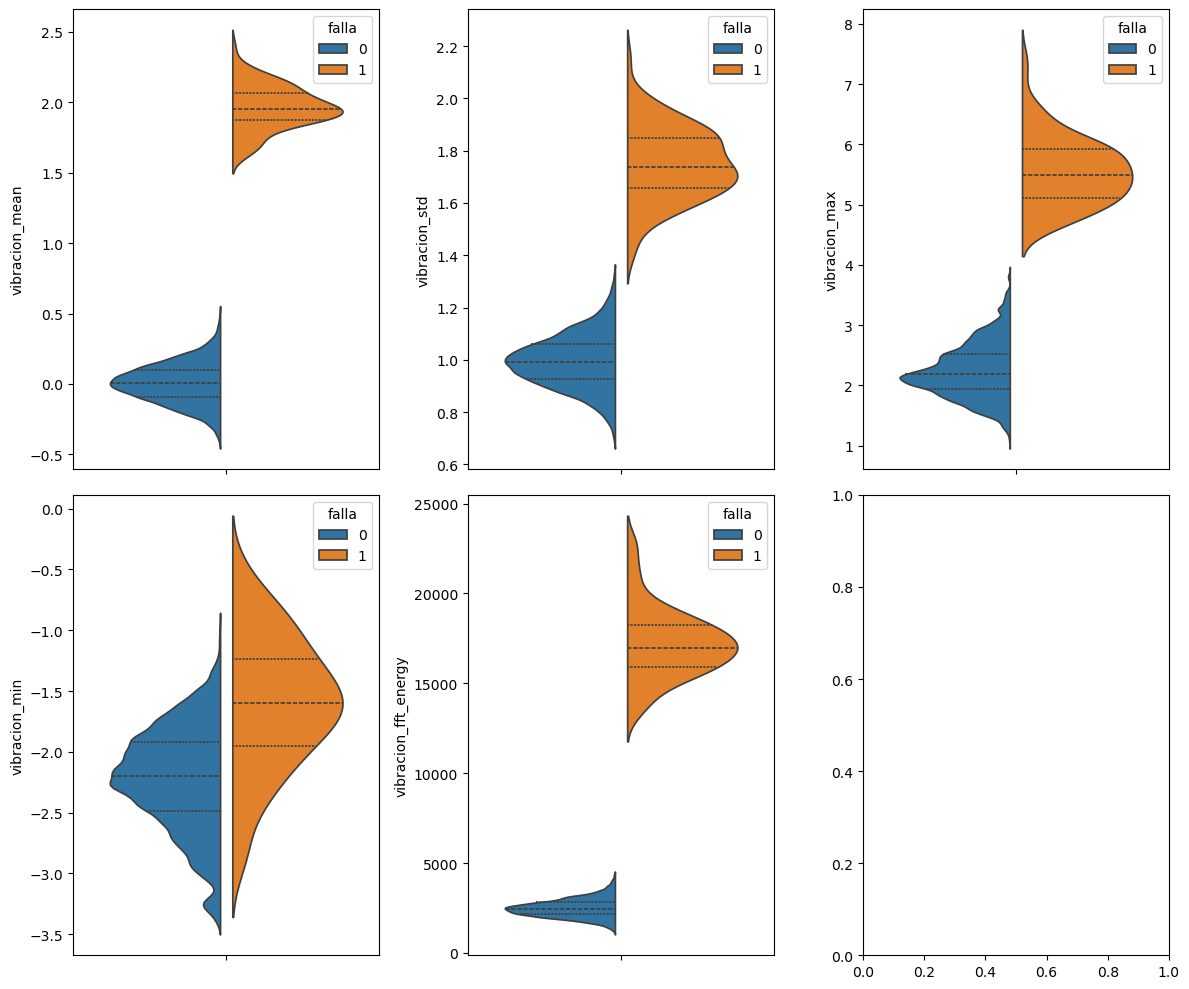

In [172]:
f, axs = plt.subplots(2, 3, figsize=(12, 10), gridspec_kw=dict(width_ratios=[1, 1, 1]))

sns.violinplot(data=df_fil, y='vibracion_mean', hue='falla', split=True, gap=.1, inner="quart",ax=axs[0,0])
sns.violinplot(data=df_fil, y='vibracion_std', hue='falla', split=True, gap=.1, inner="quart", ax=axs[0,1])
sns.violinplot(data=df_fil, y='vibracion_max', hue='falla', split=True, gap=.1, inner="quart", ax=axs[0,2])
sns.violinplot(data=df_fil, y='vibracion_min', hue='falla', split=True, gap=.1, inner="quart", ax=axs[1,0])
sns.violinplot(data=df_fil, y='vibracion_fft_energy', hue='falla', split=True, gap=.1, inner="quart", ax=axs[1,1])

f.tight_layout()
plt.show()

### Violin plots para sensor de temperatura:

Análisis, siguiendo con el análisis anterior se repite la situación. Siendo la separación de clases más evidente el de temperatura_fft_energy.

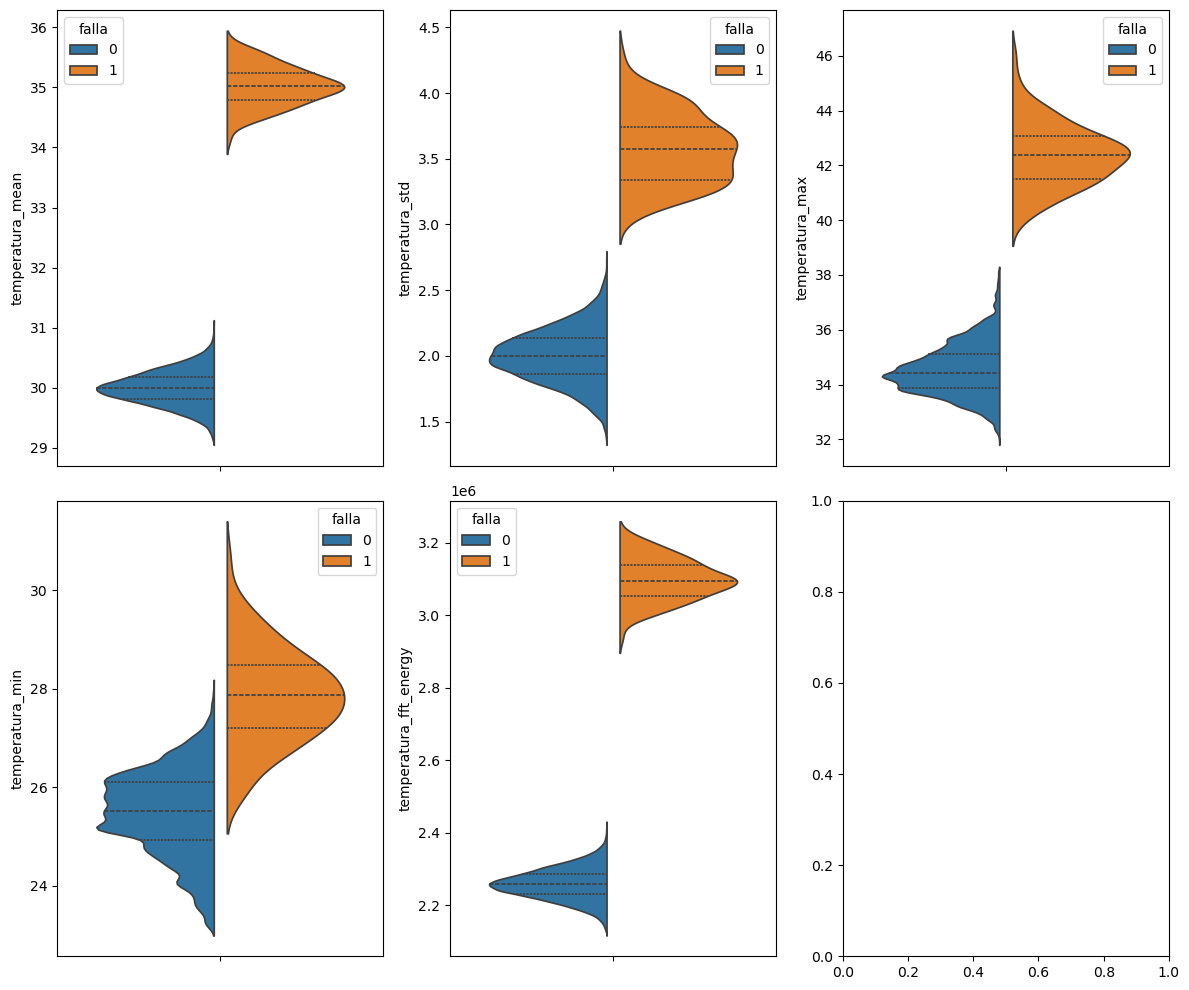

In [173]:
f, axs = plt.subplots(2, 3, figsize=(12, 10), gridspec_kw=dict(width_ratios=[1, 1, 1]))

sns.violinplot(data=df_fil, y='temperatura_mean', hue='falla', split=True, gap=.1, inner="quart",ax=axs[0,0])
sns.violinplot(data=df_fil, y='temperatura_std', hue='falla', split=True, gap=.1, inner="quart", ax=axs[0,1])
sns.violinplot(data=df_fil, y='temperatura_max', hue='falla', split=True, gap=.1, inner="quart", ax=axs[0,2])
sns.violinplot(data=df_fil, y='temperatura_min', hue='falla', split=True, gap=.1, inner="quart", ax=axs[1,0])
sns.violinplot(data=df_fil, y='temperatura_fft_energy', hue='falla', split=True, gap=.1, inner="quart", ax=axs[1,1])

f.tight_layout()
plt.show()

### Violin plots para sensor de corriente:

Análisis: Estos diagramas en la corriente difieren bastante de los anteriores, donde se podía discriminar claramente cual era la clase falla vs la clase no falla en base a los valores de las distribuciones. Esta situación no es del todo positiva, las distribuciones de las diferentes clases se "overlapean" en varios de los valores, a excepción de corriente_std, lo cual podría potencialmente confundir al clasificador si se estuviese trabajando sólo con estas features. Otra característica a mencionar es el ancho de la distribución de fallas, que suele tener valores mucho más esparcidos respecto a la otra clase. En suma, estas features no son muy buenas para determinar si hay o no una falla en el sistema si se ocupan por si solas.

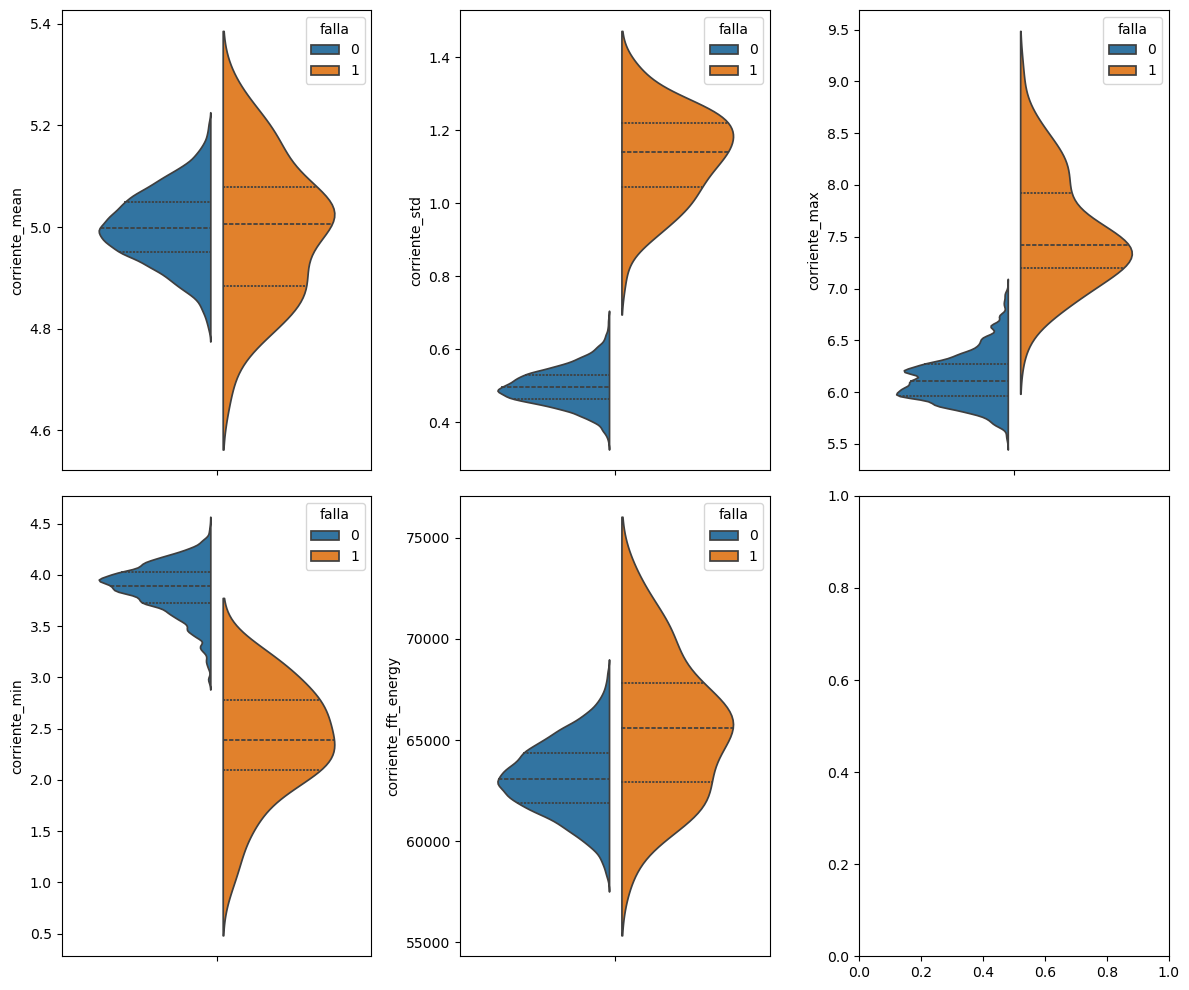

In [174]:
f, axs = plt.subplots(2, 3, figsize=(12, 10), gridspec_kw=dict(width_ratios=[1, 1, 1]))

sns.violinplot(data=df_fil, y='corriente_mean', hue='falla', split=True, gap=.1, inner="quart",ax=axs[0,0])
sns.violinplot(data=df_fil, y='corriente_std', hue='falla', split=True, gap=.1, inner="quart", ax=axs[0,1])
sns.violinplot(data=df_fil, y='corriente_max', hue='falla', split=True, gap=.1, inner="quart", ax=axs[0,2])
sns.violinplot(data=df_fil, y='corriente_min', hue='falla', split=True, gap=.1, inner="quart", ax=axs[1,0])
sns.violinplot(data=df_fil, y='corriente_fft_energy', hue='falla', split=True, gap=.1, inner="quart", ax=axs[1,1])

f.tight_layout()
plt.show()

### Heatmap

Análisis: En general se pueden notar en su mayoria correlaciones positivas. Si nos dirigimos a la feature de fallas podemos ver que hay una alta correlación con las features "vibración_fft_energy" y "temperatura_fft_energy" lo cual habíamos predecido anteriormente de tan sólo analizar los violinplots. 

En general, como habíamos mencionado, aquellas features que tienen una separación de distribuciones mucho más considerable, se correlacionan altamente con la feature de falla. Otra evidencia de esto es que, aquellas features terminadas en "_min" en todos los sensores tenía valores no tan distintos entre clases, y se puede ver en el heatmap que tienen una correlación debil/negativa respecto a la feature de interés. 

Finalmente, las otras correlaciones más fuertes se ven en features de un mismo sensor, por ejemplo: temperatura_fft_energy con temperatura_mean.

<Axes: >

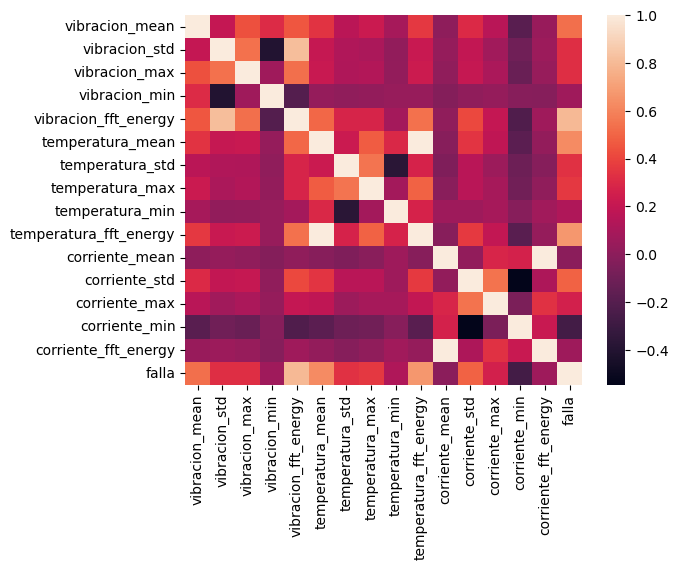

In [175]:
corr_cols = columns + ['falla']
#df_fil = df[df['falla']==1]
df_corr = df_fil[corr_cols].corr()

sns.heatmap(df_corr)

## Modelo

In [253]:
X = df_fil.drop('falla', axis=1)
y = df_fil['falla']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_base = SGDClassifier(random_state=42, class_weight='balanced', verbose=0)
param_grid = {
    'loss': ['log_loss'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['optimal'],
    'alpha': [1e-7, 1e-6, 1e-5], # Fuerza de regularización
    'max_iter': [1000, 10000, 50000, 100000],
    'tol': [1e-4, 1e-3]
}

cv_time = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    cv=cv_time,
    scoring='f1', # Métrica principal para seleccionar el mejor modelo
    return_train_score=False,
    n_jobs=-1,
    verbose=1, # Para ver el progreso de la búsqueda
    error_score='raise'
)

In [254]:
best_model=grid(X_scaled, y, cv_time, grid_search)


Realizando búsqueda de hiperparámetros con GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Resultados de la Búsqueda de Hiperparámetros

Tipo de mejor modelo: SGDClassifier
Mejor puntuación de ('f1'): 0.1155
Mejores hiperparámetros encontrados: {'alpha': 1e-05, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.0001}


Evaluando el MEJOR MODELO con todas las métricas:


Resultados de la validación cruzada estratificada (promedios):
- Recall: 0.8357 +/- 0.1275
- Precision: 0.0628 +/- 0.0169
- F1 Score: 0.1155 +/- 0.0273
- Roc Auc: 0.9864 +/- 0.0014
- Accuracy: 0.9738 +/- 0.0065

¡Búsqueda de hiperparámetros y evaluación completadas!



Métricas de Rendimiento (sobre conjunto de ENTRENAMIENTO completo):
- Recall: 0.9440
- Precision: 0.0573
- F1-Score: 0.1080
- ROC AUC: 0.9830
- Accuracy: 0.9675


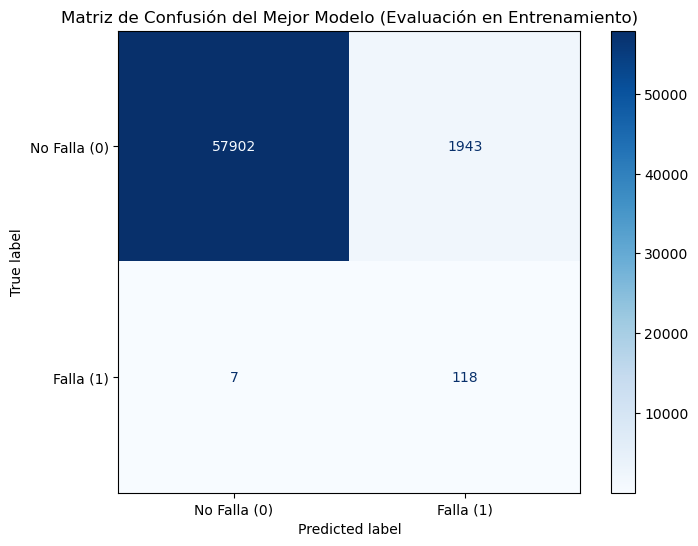

In [255]:
conf_matrix(X_scaled, y, best_model, cats = ['No Falla', 'Falla'])

## Pipeline y modelo 

In [256]:
pipeline_falla = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(
        loss='log_loss',
        learning_rate='optimal',
        penalty='elasticnet',
        class_weight='balanced',
        max_iter=1000,
        tol=0.0001,
        alpha=1e-05,
        random_state=42
    ))
])

pipeline_falla.fit(X_scaled, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SGDClassifier(alpha=1e-05, class_weight='balanced',
                               loss='log_loss', penalty='elasticnet',
                               random_state=42, tol=0.0001))])

In [258]:
joblib.dump(pipeline_falla, 'question5_falla.pkl')

['question5_falla.pkl']